# Funathon 2023 - Sujet 3

Responsables :
- Julie Sixou, D2E
- Antoine Palazzolo, SSP Lab
- Thomas Faria, SSP Lab

# Habitudes alimentaires à partir des données INCA

## Avant de commencer...

Ce sujet est disponible dans 2 langages : R et Python.
Ce notebook correspond à la version Python, qui est la plus complète des deux.

Il s'agit là principalement d'une initiation à l'analyse de données et à la data visualization, à travers l'étude des données de consommations et habitudes alimentaires de l'[étude INCA 3](https://www.data.gouv.fr/fr/datasets/donnees-de-consommations-et-habitudes-alimentaires-de-letude-inca-3/).
Le sujet est constituée de 3 parties distinctes et indépendantes :
- Analyse exploratoire des données et visualisations
- Clustering d'individus : ACP, K-moyennes, Clustering Ascendant Hiérarchique
- Prédiction de l'IMC : premiers pas vers les méthodes de ML supervisé

Il est également possible de ne faire qu'une ou deux parties du sujet. A noter que les corrigés présentés dans le sujet ne sont qu'une suggestion de comment répondre aux questions posées, mais qu'il existe évidemment d'autres manières de faire, parfois même bien meilleures.

Si jamais vous n'êtes pas familiers avec l'une des thématiques du sujet, nous ne saurions que trop vous recommander de jeter un oeil aux ressources suivantes :
- Débuter avec Pandas : https://pythonds.linogaliana.fr/pandas/
- Une introduction au clustering : https://pythonds.linogaliana.fr/clustering/
- Une introduction aux régressions en Python : https://pythonds.linogaliana.fr/regression/

Pour en savoir plus sur les données utilisées pour ce sujet et sur le contexte de l'étude : https://www.data.gouv.fr/fr/datasets/donnees-de-consommations-et-habitudes-alimentaires-de-letude-inca-3/

Pour lire la documentation associée aux données : https://static.data.gouv.fr/resources/donnees-de-consommations-et-habitudes-alimentaires-de-letude-inca-3/20210128-192017/notice-utilisateurs-donnees-inca3-data.gouvjanv21.pdf

### Imports

Si vous n'utilisez pas le Datalab, exécutez les cellules ci-dessous pour installer les packages nécessaires au sujet :

In [ ]:
!pip install --quiet -r requirements_Python.txt

In [ ]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

Exécutez également les cellules ci-dessous pour importer l'ensemble des jeux de données nécessaires à l'étude :

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)

#### Imports des données avec s3

A favoriser, en utilisant les données déjà importées sur le Datalab

In [ ]:
import pyarrow.parquet as pq
from pyarrow import csv, fs

In [ ]:
s3 = fs.S3FileSystem(endpoint_override='https://'+'minio.lab.sspcloud.fr')
bucket = "projet-funathon"
path_data = "2023/sujet3/diffusion"

In [218]:
with s3.open_input_file(f"{bucket}/{path_data}/description-indiv.csv") as file:
    description_indiv = csv.read_csv(file, parse_options=csv.ParseOptions(delimiter=";")).to_pandas()

with s3.open_input_file(f"{bucket}/{path_data}/habitudes-indiv.csv") as file:
    habitudes_indiv = csv.read_csv(file, parse_options=csv.ParseOptions(delimiter=";")).to_pandas()

with s3.open_input_file(f"{bucket}/{path_data}/actphys-sedent.csv") as file:
    actphys_sedent = csv.read_csv(file, parse_options=csv.ParseOptions(delimiter=";")).to_pandas()

with s3.open_input_file(f"{bucket}/{path_data}/fpq.csv") as file:
    fpq = csv.read_csv(file, parse_options=csv.ParseOptions(delimiter=";")).to_pandas()


# Pour la partie 3
df = pd.read_parquet(f'{bucket}/{path_data}/description_individu_inca.parquet', filesystem=s3).infer_objects()

#### Imports des données depuis data.gouv.fr

Eviter cette option pour ne pas surcharger le SSP Cloud si trop de participants font des téléchargements en même temps. A n'utiliser que si impossibilité d'utiliser le Datalab.

```python
description_indiv = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/f982ee4a-b2db-4608-ab95-bfe51dfc4897",
                            sep=";"
                            ).infer_objects()

habitudes_indiv = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/099351b9-e32e-4e38-8f23-dec21fd07c71",
                            sep=";"
                            ).infer_objects()

actphys_sedent = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/e9a34b81-2105-4d82-a023-c14947fb2b2c",
                            sep=";"
                            ).infer_objects()

fpq = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/32e79499-9897-423b-acd6-143121340f86",
                            sep=";"
                            ).infer_objects()
```

## Partie 1 : Analyse exploratoire des données et visualisations

Premier point de contact : Julie Sixou

Boîte à outils de ce qu'il est possible de faire avec ```pandas``` et ```matplotlib.pyplot```
<br>

### Imports

Explorons la base de données INCA3 : dans cette partie, nous allons vous montrer comment produire des graphes et statistiques univariées et bivariées.

Le dictionnaire des variables et des modalités peut se trouver ici : https://static.data.gouv.fr/resources/donnees-de-consommations-et-habitudes-alimentaires-de-letude-inca-3/20210128-192017/notice-utilisateurs-donnees-inca3-data.gouvjanv21.pdf

In [ ]:
# Installation de Cartiflette pour la partie "Cartographie" (nécessaire que si vous n'utilisez pas le Datalab)
!pip install git+https://github.com/inseefrlab/cartogether

In [ ]:
# Import des librairies

import cartiflette.s3
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns

from pyarrow import fs

### 1. Statistiques univariées avec la table _description_indiv_

Quelques exemples de ce qu'il est possible de faire avec ```matplotlib.pyplot``` :

In [ ]:
# Histogramme des IMC

description_indiv["imc"].hist(
    bins=100,  # Nombre de barres de l'histogramme
    range=(0, 100),  # Plage des valeurs affichées sur l'axe x
    color='skyblue',  # Couleur des barres de l'histogramme
    edgecolor='black',  # Couleur des bords des barres
    alpha=0.7  # Transparence des barres
)

plt.show()

In [ ]:
# Histogramme des niveaux de diplôme

description_indiv["diplome_interv"].hist(
    color="red",
    edgecolor="black",
    alpha=0.7
)


# Cette fois on ajoute une légende et un titre
plt.title("Histogramme des niveaux de diplôme")
plt.xlabel("Code du niveau de diplôme")
plt.ylabel("Nombre d'individus")
plt.show()

Recodons la variable des niveaux de diplôme pour mieux comprendre le graphe :

In [ ]:
# Recodage des niveaux de diplôme

dico_libelle_diplome = {1: "Aucun diplôme, n'a jamais été scolarisé", 
                        2: "Aucun diplôme, scolarité s'est arrêtée à l'école primaire", 
                        3: "Aucun diplôme, scolarité s'est arrêtée au collège",
                       4:"Aucun diplôme, scolarité s'est arrêtée au delà du collège",
                       5:"Aucun diplôme, sans précision",
                       6:"CEP",
                       7:"CAP, BEP, BEPC, brevet élémentaire, brevet de compagnon",
                       8:"Baccalauréat technologique ou professionnel, Brevet professionnel ou de technicien, BEA, BEC, BEI, BEH, capacité en droit ",
                       9:"Baccalauréat général",
                       10:"Diplôme de 1er cycle universitaire (Bac +3, licence), BTS, DUT, DEST, DEUG, diplôme des professions sociales ou de la santé, d'infirmier",
                       11:"Diplôme de 2ème cycle universitaire (Bac+4, Bac+5), Master, Maîtrise, diplôme d'ingénieur, d'une grande école",
                       12:"Diplôme de 3ème cycle universitaire (>Bac+5, doctorat), diplôme de vétérinaire, médecin, pharmacien",
                       13:"Refus",
                       14:"Ne sait pas"}

description_indiv['categorie_diplome'] = description_indiv['diplome_interv'].replace(dico_libelle_diplome)

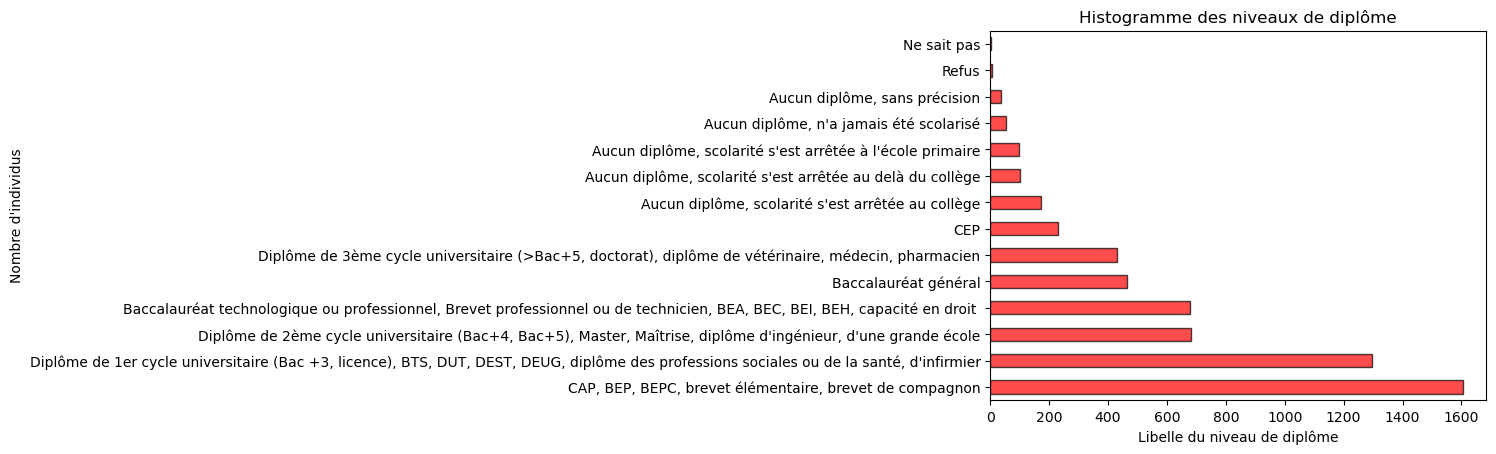

In [23]:
# Tableau des fréquences de chaque catégorie de diplome
counts_diplome = description_indiv['categorie_diplome'].value_counts()

# Graphique en barres horizontales
counts_diplome.plot(kind='barh',
                   color="red",
                   edgecolor="black",
                   alpha=0.7)


plt.title("Histogramme des niveaux de diplôme")
plt.xlabel("Libelle du niveau de diplôme")
plt.ylabel("Nombre d'individus")
plt.show()

In [25]:
# Histogramme type d'agglomération

dico_libelle_agglo = {1:"Rural",
                     2:"2000 - 19 999 hab",
                     3:"20 000 - 99 999 hab",
                     4:"+ 100 000 hab",
                     5:"Paris"}

description_indiv['categorie_agglo'] = description_indiv['agglo_5cl'].replace(dico_libelle_agglo)

In [26]:
description_indiv['agglo_5cl']

0       1
1       1
2       1
3       1
4       1
       ..
5850    5
5851    5
5852    4
5853    4
5854    5
Name: agglo_5cl, Length: 5855, dtype: int64

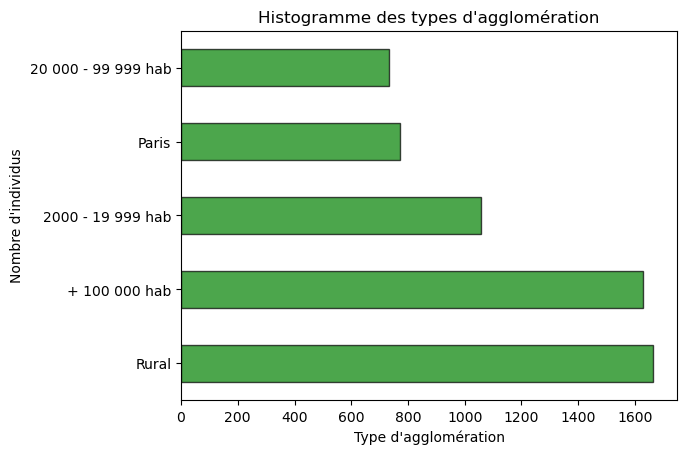

In [27]:
counts_agglo = description_indiv['categorie_agglo'].value_counts()

# Générer le graphique en barres horizontales
counts_agglo.plot(kind='barh',
                   color="green",
                   edgecolor="black",
                   alpha=0.7)


plt.title("Histogramme des types d'agglomération")
plt.xlabel("Type d'agglomération")
plt.ylabel("Nombre d'individus")
plt.show()

A vous de jouer, faites la même chose pour les tranches de revenu : histogramme de la variable **RUC_4cl** qui donne le revenu mensuel total du foyer par unité de consommation (UC) en 4 classes. Les modalités de la variable sont les suivantes :

In [44]:
# Niveau de vie

dico_RUC = {1:"<900 €/mois/UC",
            2:"[900-1 340[ €/mois/UC",
            3:"[1 340-1 850[ €/mois/U",
            4:">=1 850 €/mois/UC"}

RUC_4cl_label
[900-1 340[ €/mois/UC     1362
<900 €/mois/UC            1355
>=1 850 €/mois/UC         1341
[1 340-1 850[ €/mois/U    1339
Name: count, dtype: int64

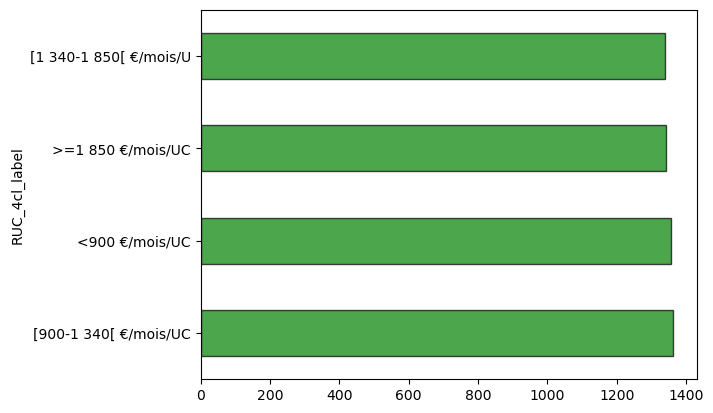

In [48]:
# TODO
description_indiv['RUC_4cl_label'] = description_indiv['RUC_4cl'].replace(dico_RUC)
tranche_revenu_count = description_indiv['RUC_4cl_label'].value_counts()#.sort_values(ascending=False)
tranche_revenu_count.plot(kind='barh',
                   color="green",
                   edgecolor="black",
                   alpha=0.7)
tranche_revenu_count

In [35]:
description_indiv['RUC_4cl_label']

0       [1 340-1 850[ €/mois/U
1            >=1 850 €/mois/UC
2        [900-1 340[ €/mois/UC
3            >=1 850 €/mois/UC
4               <900 €/mois/UC
                 ...          
5850     [900-1 340[ €/mois/UC
5851     [900-1 340[ €/mois/UC
5852         >=1 850 €/mois/UC
5853            <900 €/mois/UC
5854    [1 340-1 850[ €/mois/U
Name: RUC_4cl_label, Length: 5855, dtype: object

In [30]:
tranche_revenu_count

RUC_4cl_label
[900-1 340[ €/mois/UC     1362
<900 €/mois/UC            1355
>=1 850 €/mois/UC         1341
[1 340-1 850[ €/mois/U    1339
Name: count, dtype: int64

### 2. Statistiques bivariées avec les tables _description_indiv_ et _habitudes_indiv_

Quelques exemples de ce qu'il est possible de faire avec ```matplotlib.pyplot``` :

In [31]:
description_indiv.columns

Index(['NOMEN', 'NOIND', 'ech', 'enf_allaite', 'pop1', 'pop2', 'pop3',
       'pond_indiv_adu_pop1', 'pond_indiv_enf_pop1', 'pond_indiv_adu_pop2',
       ...
       'bmr_kcal', 'sousest0', 'surest0', 'sousest1', 'sousest3', 'sousext',
       'surext', 'categorie_diplome', 'categorie_agglo', 'RUC_4cl_label'],
      dtype='object', length=188)

[]

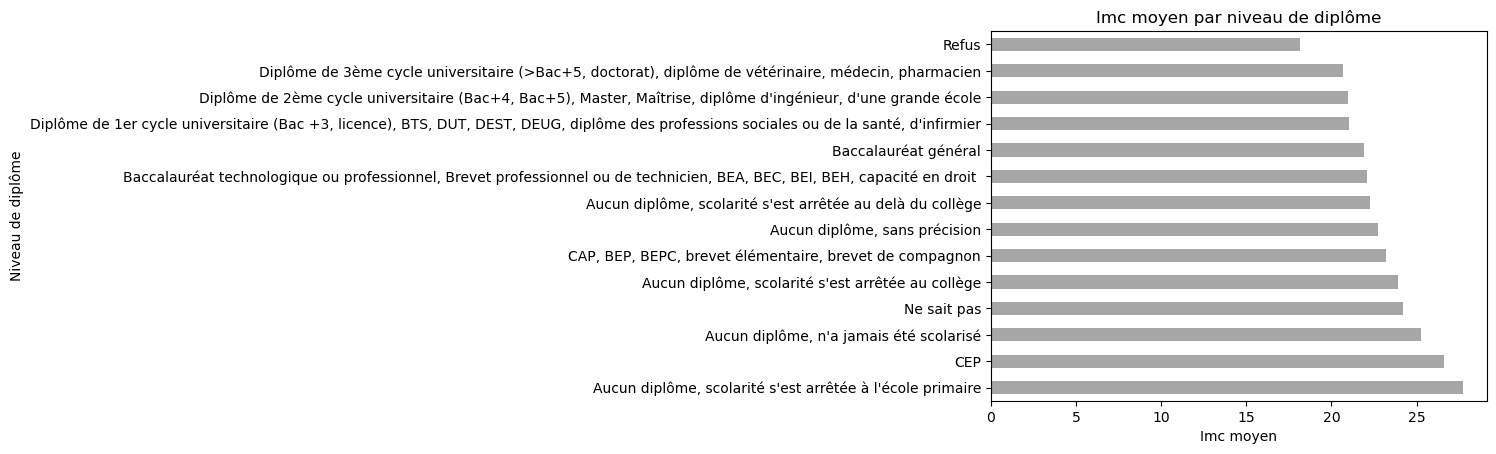

In [49]:
# Imc moyen par niveau de diplôme

imc_par_diplome = description_indiv.groupby('categorie_diplome')['imc'].mean().sort_values(ascending=False)
imc_par_diplome.plot(kind='barh',
                    color="grey",
                    alpha=0.7)

plt.title('Imc moyen par niveau de diplôme')
plt.xlabel('Imc moyen')
plt.ylabel('Niveau de diplôme')
plt.plot()

[]

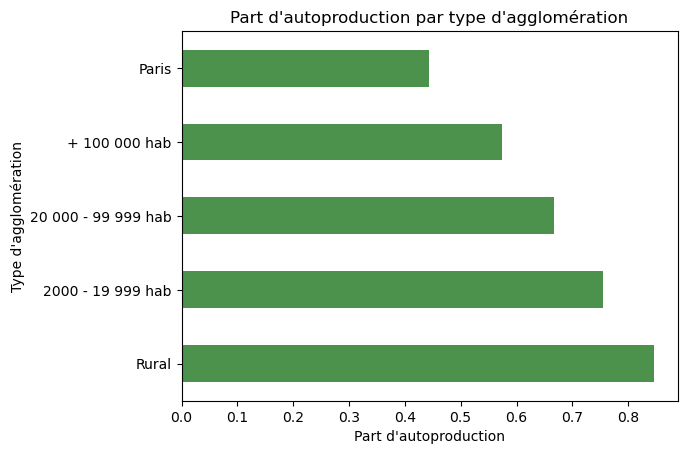

In [50]:
# Autoproduction par type d'agglomération

description_x_habitudes = pd.merge(description_indiv, habitudes_indiv,on="NOIND")
autoprod_par_agglo = description_x_habitudes.groupby('categorie_agglo')['autoproduction'].mean().sort_values(ascending=False)
autoprod_par_agglo.plot(kind='barh',
                    color="darkgreen",
                    alpha=0.7)

plt.title("Part d'autoproduction par type d'agglomération")
plt.xlabel("Part d'autoproduction")
plt.ylabel("Type d'agglomération")
plt.plot()

A vous de jouer, représentez le croisement entre le score d'insécurité d'alimentaire (**IA_score**, on peut en faire la moyenne) et les tranches de revenu (par exemple, **RUC_4cl** qu'on a recodée précédemment, ou **revenu** qui donne le revenu disponible codé en plus de classes.)

Le dictionnaire des variables et des modalités peut se trouver ici : https://static.data.gouv.fr/resources/donnees-de-consommations-et-habitudes-alimentaires-de-letude-inca-3/20210128-192017/notice-utilisateurs-donnees-inca3-data.gouvjanv21.pdf

RUC_4cl_label
<900 €/mois/UC            5.115756
[900-1 340[ €/mois/UC     4.250761
[1 340-1 850[ €/mois/U    3.958101
>=1 850 €/mois/UC         3.599643
Name: IA_score, dtype: float64

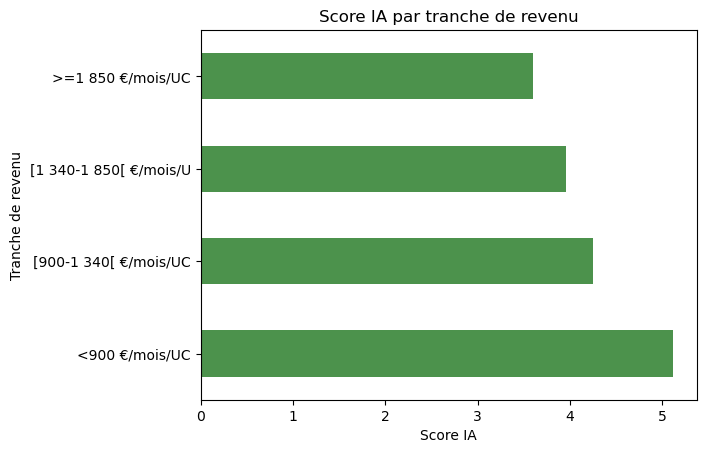

In [51]:
# Score d'IA par tranche de revenu

score_ia_par_revenu = description_x_habitudes.groupby('RUC_4cl_label')['IA_score'].mean().sort_values(ascending=False)
score_ia_par_revenu.plot(kind='barh',
                    color="darkgreen",
                    alpha=0.7)
plt.title("Score IA par tranche de revenu")
plt.xlabel("Score IA")
plt.ylabel("Tranche de revenu")
plt.plot()
score_ia_par_revenu


Finalement, on se rend compte que la base est très riche et contient beaucoup de variables : beaucoup d'entre elles sont quantitatives, et on peut s'amuser à représenter leurs relations de corrélations en même temps dans une matrice de corrélation.

<Axes: >

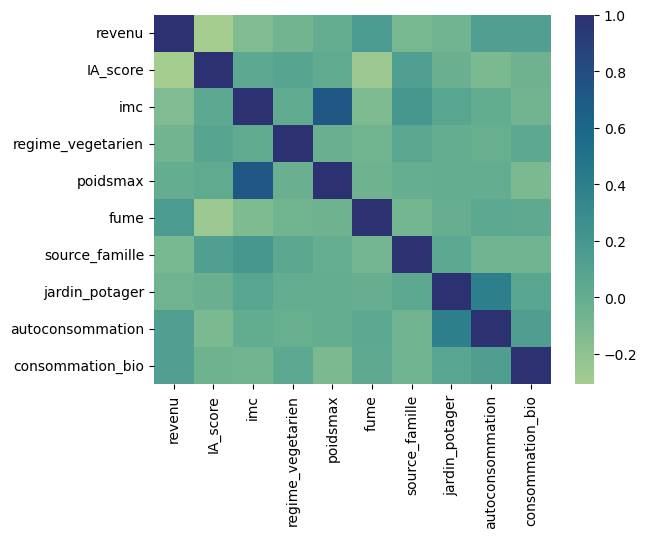

In [67]:
# Matrice de corrélation

df_num = description_x_habitudes.select_dtypes(include=['int', 'float'])
df_num=df_num[["revenu","IA_score","imc","regime_vegetarien","poidsmax","fume","source_famille","jardin_potager","autoconsommation","consommation_bio"]]
matrice_correlation = df_num.corr()
matrice_correlation

sns.heatmap(matrice_correlation, annot=False, cmap='crest')

In [55]:
description_x_habitudes.head()

,NOMEN,NOIND,ech,enf_allaite,pop1,pop2,pop3,pond_indiv_adu_pop1,pond_indiv_enf_pop1,pond_indiv_adu_pop2,pond_indiv_enf_pop2,pond_indiv_adu_pop3,pond_indiv_enf_pop3,pond_men_pop1,pond_men_pop2,zae,strate,fpc1,fpc2,fpc3,saison_pop1,saison_pop2,saison_pop3,region_adm_12cl,region_inca3,agglo_5cl,sex_PS,tage_PS,tage_PS_mois,lien_rep_enf,diplome_interv,etude_4cl_interv,situ_prof_5cl_interv,atrav_interv,trav_nuit_interv,trav_nuit_2cl_interv,PCS_8cl_interv,PCS_4cl_interv,tps_travail_interv,vacances_interv,interv_PR,sex_PR,tage_PR,lien_interv_PR,lien_PS_PR,diplome_PR,etude_4cl_PR,atrav_PR,PCS_8cl_PR,PCS_4cl_PR,tps_travail_PR,stat_log_2cl,soins,situ_fin_3cl,revenu,RUC_4cl,nbpers,nbadu,nbenf,situ_alim_statut,IA_statut,IA_score,taille_m,taille_d,taille,poids_m,poids_d,poids,imc,statnut,maladie_allergie_alim,intoall_confirm_med,regime_vegetarien,regime_allergie,regime_maigrir_med,regime_maigrir_choix,regime_autre_med,regime_raisonmed_libelle,regime_poidsstable,regime_forme,regime_autreraison,regime_non,veget_viande,veget_prodmer,veget_prodlait,veget_oeuf,veget_miel,veget_autre_alim,veget_autre_alim_libelle,allergie_laitvache,allergie_prepainfsoja,allergie_prepainfamande,allergie_gluten,allergie_farineble,allergie_lupin,allergie_arachide,allergie_fruitcoque,allergie_fruitcoque_libelle,allergie_oeuf,allergie_poisson,allergie_crustace,allergie_mollusque,allergie_soja,allergie_sesame,allergie_moutarde,allergie_sulfite,allergie_celeri,allergie_autres_fruitleg,allergie_autres_fl_libelle,allergie_autresalim,allergie_autresalim_libelle,allergie_nondetermine,allergie_fruits,allergie_legumes,regime_passe,regime_nb_2dernann,regime_nb_anter2dernann,regime_type,regime_type_libelle,regime_duree_sem,regime_duree_mois,regime_duree_nsp,poids_anndern,poids_anndern_nsp,poids_modif,poids_modifalim,poids_plusAP,poids_medicaments,poids_substituts,poids_chirurgie,poids_modifalim_laityaourt,poids_modifalim_fromage,poids_modifalim_mg,poids_modifalim_fruit,poids_modifalim_legume,poids_modifalim_pdtfeculent,poids_modifalim_pizza,poids_modifalim_pain,poids_modifalim_vrouge,poids_modifalim_volaille,poids_modifalim_oeuf,poids_modifalim_gateau,poids_modifalim_edulcorant,poids_modifalim_pdtsalleges,poids_modifalim_BS,poids_modifalim_eau,poids_modifalim_autre,poids_modifalim_autre_libelle,poids_perception,poidsmax,poidsmax_nsp,age_poidsmax,age_poidsmax_nsp,poidsmin,poidsmin_nsp,age_poidsmin,age_poidsmin_nsp,nb_prise_10kg,menopause,enceinte,enceinte_nbmois,allaite,allaite_nbsem,enceinte_12dermois,fume,nb_cigarettes_jour,nb_cigarettes_sem,nb_cigarettes_nsp,nb_cigares_jour,nb_cigares_sem,nb_cigares_nsp,nb_pipes_jour,nb_pipes_sem,nb_pipes_nsp,fume_age_debut,fume_age_debut_nsp,fume_age_arret,fume_age_arret_nsp,bmr_kcal,sousest0,surest0,sousest1,sousest3,sousext,surext,categorie_diplome,categorie_agglo,RUC_4cl_label,POPULATION,periode_reference,repasenfantmidi_vous,repasenfantmidi_am,repasenfantmidi_creche,repasenfantmidi_parent,repasenfantmidi_autre,repasenfantmidi_autre_libelle,repasenfant_freq,conso_bebe_sein,lait_plussouvent,lait_plusvt_li_autr_anim_libelle,lait_plusvt_pi_autre_veg_libelle,lait_plusvt_boisson_veg_libelle,lait_plusvt_autre_anim_libelle,lait_plusvt_autre_libelle,lait_occ_laitmaternel,lait_occ_lait_1e_age,lait_occ_lait_2e_age,lait_occ_lait_croissance,lait_occ_li_autre_anim,lait_occ_li_autre_anim_libelle,lait_occ_li1e_age_protsoja,lait_occ_li2e_age_protsoja,lait_occ_soja_croissance,lait_occ_li1e_age_protriz,lait_occ_li2e_age_protriz,lait_occ_riz_croissance,lait_occ_pi_autre_veg,lait_occ_pi_autre_veg_libelle,lait_occ_boisson_lait_bebe,lait_occ_lait_regime_infantile,lait_occ_lait_vache,lait_occ_boisson_soja,lait_occ_boisson_veg,lait_occ_boisson_veg_libelle,lait_occ_autre_anim,lait_occ_autre_anim_libelle,lait_occ_autre,lait_occ_autre_libelle,lait_occ_aucun,lait_occ_nsp,etablissement_scolaire,lieu_repas_midi,lieu_repas_midi_autre_libelle,cantine_freq,cantine_jms_persfoyer,cantine_jms_veutpas,cantine_jms_probsante,cantine_jms_repaspasequilibre,cantine_jms_repaspasqu

A vous d'ajouter les variables qui vous intéressent et à multiplier les visualisations !
Les plus beaux graphes seront partagés à l'issue du funathon.

In [ ]:
# TODO

### 3. Cartographie

Pour la cartographie, on a besoin de fonds de carte. Ce sont des bases d'objets vectoriels. Par exemple, pour une carte de France par région, on aura une ligne par région avec un attribut géographique renseignant les coordonnées du vecteur (ou polygone). Le package **cartiflette** nous permet de les télécharger directement et facilement.

https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=REGION/crs=4326/FRANCE_ENTIERE=metropole/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 4.76MiB [00:00, 56.6MiB/s]
ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


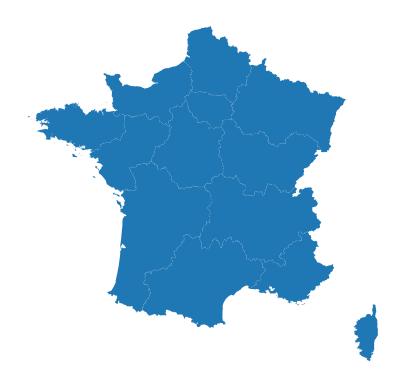

In [68]:
region = cartiflette.s3.download_vectorfile_url_all(
    crs = 4326,
    values = "metropole",
    borders="REGION", # notre unité géographique
    vectorfile_format="topojson",
    filter_by="FRANCE_ENTIERE", # le champ qui nous intéresse
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022)
ax = region.plot()
ax.set_axis_off()

In [71]:
region.head()

,id,ID,NOM_M,NOM,INSEE_REG,source,territoire,geometry
0,REGION_FXX_0000000000001,NaN,ILE-DE-FRANCE,Île-de-France,11,IGN:EXPRESS-COG-CARTO-TERRITOIRE,metropole,"POLYGON ((2.94279 49.07828, 2.94294 49.07828, ..."
1,REGION_FXX_0000000000002,NaN,CENTRE-VAL DE LOIRE,Centre-Val de Loire,24,IGN:EXPRESS-COG-CARTO-TERRITOIRE,metropole,"POLYGON ((2.34194 48.31617, 2.34224 48.31617, ..."
2,REGION_FXX_0000000000003,NaN,BOURGOGNE-FRANCHE-COMTE,Bourgogne-Franche-Comté,27,IGN:EXPRESS-COG-CARTO-TERRITOIRE,metropole,"POLYGON ((7.01658 47.64695, 7.01644 47.64695, ..."
3,REGION_FXX_0000000000004,NaN,NORMANDIE,Normandie,28,IGN:EXPRESS-COG-CARTO-TERRITOIRE,metropole,"MULTIPOLYGON (((-1.51177 48.66055, -1.51162 48..."
4,REGION_FXX_0000000000005,NaN,HAUTS-DE-FRANCE,Hauts-de-France,32,IGN:EXPRESS-COG-CARTO-TERRITOIRE,metropole,"POLYGON ((2.72418 49.08072, 2.72418 49.08062, ..."


On va s'intéresser aux fréquences de consommation de certains aliments, présentes dans la table fpq.

In [79]:
description_x_fpq = pd.merge(description_indiv,fpq,on="NOIND")

In [80]:
# Recodage de la variable région pour avoir les mêmes noms que dans notre fond de carte (qu'on vient de télécharger avec cartiflette)

dico_libelle_region = {1:"ILE-DE-FRANCE",
                      2:"NORMANDIE",
                      3:"CENTRE-VAL DE LOIRE",
                      4:"PAYS DE LA LOIRE",
                      5:"BRETAGNE",
                      6:"HAUTS-DE-FRANCE",
                      7:"GRAND EST",
                      8:"BOURGOGNE-FRANCHE-COMTE",
                      9:"AUVERGNE-RHONE-ALPES",
                      10:"PROVENCE-ALPES-COTE D'AZUR",
                      11:"OCCITANIE",
                      12:"NOUVELLE-AQUITAINE"}

description_x_fpq["region_recode"]=description_x_fpq['region_adm_12cl'].replace(dico_libelle_region)

In [81]:
# Variable à représenter géographiquement : nombre de bière consommées par mois. 

biere_par_region = description_x_fpq.groupby('region_recode')['BA_biere_freq_M'].mean()
biere_par_region

region_recode
AUVERGNE-RHONE-ALPES          5.205775
BOURGOGNE-FRANCHE-COMTE       5.630435
BRETAGNE                      6.551802
CENTRE-VAL DE LOIRE           3.404255
GRAND EST                     5.797945
HAUTS-DE-FRANCE               6.303672
ILE-DE-FRANCE                 4.288275
NORMANDIE                     5.388889
NOUVELLE-AQUITAINE            4.390625
OCCITANIE                     4.109873
PAYS DE LA LOIRE              3.769676
PROVENCE-ALPES-COTE D'AZUR    4.062281
Name: BA_biere_freq_M, dtype: float64

In [83]:
# On crée un petit tableau avec nos régions et leurs attributs géographiques, 
# et surtout la variable qu'on vient de calculer (c'est-à-dire le nombre de bières consommées par mois par région en moyenne)

region_inca=pd.merge(region,biere_par_region,left_on="NOM_M",right_on="region_recode")
region_inca

,id,ID,NOM_M,NOM,INSEE_REG,source,territoire,geometry,BA_biere_freq_M
0,REGION_FXX_0000000000001,NaN,ILE-DE-FRANCE,Île-de-France,11,IGN:EXPRESS-COG-CARTO-TERRITOIRE,metropole,"POLYGON ((2.94279 49.07828, 2.94294 49.07828, ...",4.288275
1,REGION_FXX_0000000000002,NaN,CENTRE-VAL DE LOIRE,Centre-Val de Loire,24,IGN:EXPRESS-COG-CARTO-TERRITOIRE,metropole,"POLYGON ((2.34194 48.31617, 2.34224 48.31617, ...",3.404255
2,REGION_FXX_0000000000003,NaN,BOURGOGNE-FRANCHE-COMTE,Bourgogne-Franche-Comté,27,IGN:EXPRESS-COG-CARTO-TERRITOIRE,metropole,"POLYGON ((7.01658 47.64695, 7.01644 47.64695, ...",5.630435
3,REGION_FXX_0000000000004,NaN,NORMANDIE,Normandie,28,IGN:EXPRESS-COG-CARTO-TERRITOIRE,metropole,"MULTIPOLYGON (((-1.51177 48.66055, -1.51162 48...",5.388889
4,REGION_FXX_0000000000005,NaN,HAUTS-DE-FRANCE,Hauts-de-France,32,IGN:EXPRESS-COG-CARTO-TERRITOIRE,metropole,"POLYGON ((2.72418 49.08072, 2.72418 49.08062, ...",6.303672
5,REGION_FXX_0000000000006,NaN,GRAND EST,Grand Est,44,IGN:EXPRESS-COG-CARTO-TERRITOIRE,metropole,"POLYGON ((5.10156 47.65953, 5.10156 47.65963, ...",5.797945
6,REGION_FXX_0000000000007,NaN,PAYS DE LA LOIRE,Pays de la Loire,52,IGN:EXPRESS-COG-CARTO-TERRITOIRE,metropole,"MULTIPOLYGON (((-2.35799 47.04230, -2.35799 47...",3.769676
7,REGION_FXX_0000000000008,NaN,BRETAGNE,Bretagne,53,IGN:EXPRESS-COG-CARTO-TERRITOIRE,metropole,"MULTIPOLYGON (((-4.01308 47.70860, -4.01323 47...",6.551802
8,REGION_FXX_0000000000009,NaN,NOUVELLE-AQUITAINE,Nouvelle-Aquitaine,75,IGN:EXPRESS-COG-CARTO-TERRITOIRE,metropole,"MULTIPOLYGON (((-1.17334 45.58609, -1.17348 45...",4.390625
9,REGION_FXX_0000000000010,NaN,OCCITANIE,Occitanie,76,IGN:EXPRESS-COG-CARTO-TERRITOIRE,metropole,"MULTIPOLYGON (((-0.08763 43.33373, -0.08763 43...",4.109873


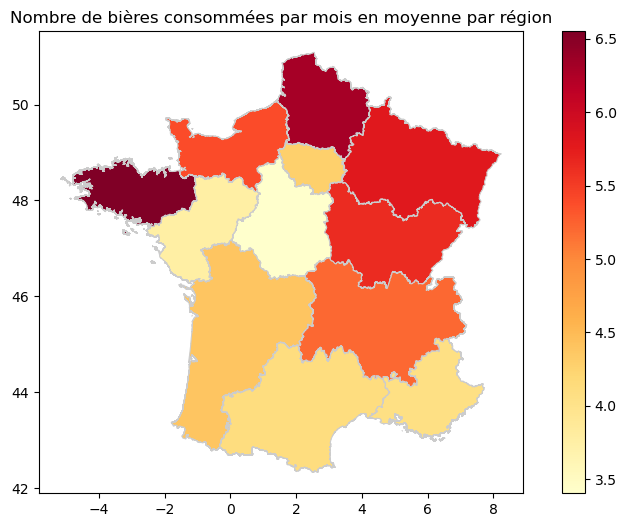

In [77]:
# Créez une figure et des axes
fig, ax = plt.subplots(figsize=(10, 6))

# Dessinez la carte choroplèthe
region_inca.plot(column='BA_biere_freq_M', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8')

# Ajoutez une légende
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=region_inca['BA_biere_freq_M'].min(), vmax=region_inca['BA_biere_freq_M'].max()))
plt.colorbar(sm, ax=ax)
plt.title("Nombre de bières consommées par mois en moyenne par région")

# Affichez le graphique
plt.show()


Maintenant, créez votre propre carte ! Vous pouvez regarder directement dans le dictionnaire des variables, ou bien vous aider des libellés. Les fréquences en nombre de jours par mois finissent par _freq_M, et les indicatrices de consommation finissent par _ON (ces dernières valent 1 si le produit est consommé et 0 sinon). 

Par exemple, on peut choisir parmi les variables dans : ```fpq.columns.tolist()```

In [100]:
# TODO



In [308]:
# BONUS : Corrélations entre consommations mensuelles d'aliments

# Output souhaité : Top K des produits consommés la plus corrélée (positivement ou négativement)

# on récupère les variables de fréquence de conso (suffixées freq_M) 
variables_freq_M = [ variable for variable in fpq.columns.tolist() if 'freq_M' in variable ]
variables_freq_M

fpq_freq_M = fpq[ variables_freq_M ].fillna(0)
fpq_freq_M

matrice_correlation = fpq_freq_M.corr()
matrice_correlation

# transformation matrice des orrélations en dataframe des paires de corrélations
correlations = matrice_correlation.stack().reset_index()
#set column names
correlations.columns = ['item1','item2','correlation']
#print (correlations)


correlations['categorie_item1'] = correlations.item1.str[:3]
correlations['categorie_item2'] = correlations.item2.str[:3]
correlations

# suppression des lignes où les 2 items ont la même catégorie
correlations =  correlations.drop(correlations[(correlations.categorie_item1 == correlations.categorie_item2)].index)
correlations = correlations[~correlations['item1'].str.contains('tot')]
correlations = correlations[~correlations['item2'].str.contains('tot')]
#correlations =  correlations.drop(correlations[('tot' in correlations.item1)].index)

top_combos_max_cor = correlations.sort_values(by='correlation', ascending=False).head(10)
top_combos_min_cor = correlations.sort_values(by='correlation', ascending=True).head(10)



In [309]:
top_combos_max_cor

,item1,item2,correlation,categorie_item1,categorie_item2
31128,PL_yaourt_entremet_freq_M,BIS_biscuit_maison_freq_M,0.754089,PL_,BIS
35688,BIS_biscuit_maison_freq_M,PL_yaourt_entremet_freq_M,0.754089,BIS,PL_
27284,VC_boeuf_maison_freq_M,PL_yaourt_entremet_freq_M,0.741766,VC_,PL_
31084,PL_yaourt_entremet_freq_M,VC_boeuf_maison_freq_M,0.741766,PL_,VC_
31088,PL_yaourt_entremet_freq_M,VC_poulet_maison_freq_M,0.741208,PL_,VC_
28048,VC_poulet_maison_freq_M,PL_yaourt_entremet_freq_M,0.741208,VC_,PL_
23082,LEG_haricot_freq_M,PL_yaourt_entremet_freq_M,0.734691,LEG,PL_
31062,PL_yaourt_entremet_freq_M,LEG_haricot_freq_M,0.734691,PL_,LEG
32823,FR_banane_freq_M,PL_yaourt_entremet_freq_M,0.730462,FR_,PL_
31113,PL_yaourt_entremet_freq_M,FR_banane_freq_M,0.730462,PL_,FR_


In [310]:
top_combos_min_cor

,item1,item2,correlation,categorie_item1,categorie_item2
10691,PL_yaourtentremet_freq_M,BIS_biscuit_maison_freq_M,-0.268984,PL_,BIS
35581,BIS_biscuit_maison_freq_M,PL_yaourtentremet_freq_M,-0.268984,BIS,PL_
10625,PL_yaourtentremet_freq_M,LEG_haricot_freq_M,-0.265552,PL_,LEG
22975,LEG_haricot_freq_M,PL_yaourtentremet_freq_M,-0.265552,LEG,PL_
10651,PL_yaourtentremet_freq_M,VC_poulet_maison_freq_M,-0.263379,PL_,VC_
27941,VC_poulet_maison_freq_M,PL_yaourtentremet_freq_M,-0.263379,VC_,PL_
10627,PL_yaourtentremet_freq_M,LEG_haricot_maison_freq_M,-0.261089,PL_,LEG
23357,LEG_haricot_maison_freq_M,PL_yaourtentremet_freq_M,-0.261089,LEG,PL_
27177,VC_boeuf_maison_freq_M,PL_yaourtentremet_freq_M,-0.259269,VC_,PL_
10647,PL_yaourtentremet_freq_M,VC_boeuf_maison_freq_M,-0.259269,PL_,VC_


## Partie 2 : Clustering d'individus

Premier point de contact : Antoine Palazzolo

Lorsque l'on pense au Machine Learning, les premiers exemples qui viennent en tête sont souvent des problèmes de régression ou bien de classification.
Ces cas d'usage font partie d'une branche du ML appelée _apprentissage supervisé_, qui requiert notamment d'avoir des données labellisées permettant aux diverses méthodes utilisées de comprendre la relation entre un ensemble de variables explicatives et une variable à prédire.

_L'apprentissage non supervisé_ est une autre branche du ML qui ne consiste cette fois plus à prédire une variable donnée à partir de données labellisées.
Au coeur de l'apprentissage non supervisé on trouve notamment le __clustering__.
Cette fois-ci, le but est de créer à partir d'une population donnée un ensemble de clusters (ou paquets) d'individus regroupés par similarité, en utilisant de façon automatiques les caractéristiques les plus discriminantes de notre population. Ce sera peut-être plus clair avec quelques exemples et applications :
- Une enseigne de retail possède une centaine de magasins en France et souhaite regrouper ces derniers en une poignée de groupes qu'elle pourra approvisionner de la même façon. Chaque groupe devra regrouper des magasins ayant des performances similaires et une clientèle proche. C'est un problème de clustering.
- A partir d'une base de données regroupant les thèmes de prédilection de centaines de journalistes (ou bien leurs références), on souhaite regrouper ces mêmes journalistes en quelques catégories au sein desquelles chaque individu aura une orientation politique proche de celles des autres.
- En fonction des caractéristiques physiques d'espèces animales ou végétales, on souhaite regrouper ces espèces en un plus petit nombre de groupes.



Il existe plusieurs méthodes pour faire du clustering, les deux plus connues étant :
- Les [K-Moyennes](https://fr.wikipedia.org/wiki/K-moyennes) (ou K-Means), méthode la plus connue, basée sur l'utilisation de centroïdes itérés
- Le [Clustering Ascendant Hiérarchique](https://fr.wikipedia.org/wiki/Regroupement_hi%C3%A9rarchique) (CAH), basé sur des regroupements en groupes de plus en plus grands, donnant par exemple lieu à des visualisations sous forme de dendrogrammes (ressemblant aux arbres phylogénétiques de vos cours de SVT au lycée)

Nous allons mettre en pratique ces deux méthodes dans ce sujet.

Une fois nos clusterings effectués, l'un des enjeux est ensuite aussi de pouvoir interpréter ces derniers :
- Quelles sont les caractéristiques les plus discriminantes dans la constitution des groupes ?
- Les clusters générés font-ils bien sens ? Que peut-on dire de ces groupes ?
- Quelles méthodes de visualisation sont les plus adaptées ?

Pour répondre à ces questions, un des outils principaux que nous pouvons utiliser est l'[Analyse en Composantes Principales](https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales) (ACP), qui à partir de l'ensemble initial des colonnes en crée un ensemble de taille réduite qui maximise la discrimination des données les unes par rapport aux autres via ces nouvelles colonnes.
En réduisant la dimension à moins de 3, on peut ainsi représenter graphiquement les données de façon plus claire.

### 1. Preprocessing des données

Pour cette étude nous allons commencer par la table des habitudes individuelles.
Cette table contient les données des questionnaires auto-administrés relatifs aux volets « Habitudes alimentaires » et « Origine des aliments ».

Elle regroupe les informations suivantes : lieux et occasions de consommation, consommations hors-foyer et entre les repas, préférences alimentaires, présence de sel/beurre/sauce sur la table au moment des repas, lecture des étiquettes, sources d’informations en alimentation, consommation de denrées animales crues et des croûtes de fromage, préparation des fruits et légumes crus, spécificités de l’alimentation des enfants de 0 à 35 mois (ex : allaitement (exclusif ou partiel), type de laits consommés, diversification alimentaire, matériaux des biberons et des tétines, préparation, stockage et conservation des biberons de lait, mode de chauffage des laits et contenants utilisés), autoconsommation et utilisation de produits phytosanitaires au potager, consommation d’aliments issus de l’agriculture biologique et cuisson des aliments au barbecue.

Une fois le sujet terminé, vous pourrez si vous le souhaitez reproduire cette partie avec d'autres des tables à disposition.

In [ ]:
habitudes_indiv.shape

In [ ]:
habitudes_indiv.head(3)

#### Etape 1 : Analyse exploratoire & sélection de variables

Regardons déjà à quoi ressemblent nos données en pratique. En utilisant Pandas, pouvez-vous dire :
- Combien y a-t-il d'individus et de variables ?
- Combien de variables présentent des valeurs vides ? En quelle proportion ?
- Y a-t-il des variables qui ont la même valeur pour tous les individus ? Seront-elles utiles pour la discrimination des observations dans le clustering ?
- Y a-t-il des variables qui n'ont pas de sens pour la caractérisation d'un groupe ? Cela comprend par exemple les identifiants.
- Quels sont les types des variables ? Combien de variables non-numériques ? En pratique nous allons ici nous focaliser uniquement sur les données numériques de la table.

In [ ]:
# A vous de jouer !

# TODO

A partir des analyses que vous venez de réaliser, vous devriez avoir une meilleure idée de quoi garder dans la table pour appliquer les méthodes de clustering. Créez donc ```habitudes_indiv_clustering_1``` à partir de ```habitudes_indiv``` en retirant toutes les colonnes gênantes ou inutiles :

<details>
<summary> Si besoin, dérouler pour révéler les indications plus détaillées :</summary>
<br>

Il vous faudra donc, a minima :
- Retirer les colonnes d'identifiants
- Retirer les colonnes vides
- Conserver uniquement les colonnes numériques

Pour aller plus loin, retirez les colonnes à moins de 2 valeurs distinctes.

</details>


In [ ]:
habitudes_indiv_clustering_1 = pd.DataFrame() # TODO

habitudes_indiv_clustering_1.shape

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```python
# Sélectionner les caractéristiques pour le clustering

habitudes_indiv_clustering_1 = habitudes_indiv.drop(
    ['POPULATION', 'NOIND', 'periode_reference'],  # Identifiants
    axis=1
).dropna(
    axis=1, how='all'  # Colonnes vides
).select_dtypes(
    include=np.number  # Colonnes numériques à garder
)

habitudes_indiv_clustering_1 = habitudes_indiv_clustering_1.loc[
    :, habitudes_indiv_clustering_1.nunique() > 1
]  # On retire les colonnes avec moins de 2 valeurs distinctes

habitudes_indiv_clustering_1.shape
```

</details>


#### Etape 2 : Imputation

Comme vous l'avez peut-être vu, si l'on cherche à retirer toutes les lignes ou colonnes avec au moins une valeur manquante, il ne reste plus grand-chose à la table...
Nous allons donc les garder, d'autant plus que cela ne les empêche pas de contenir de l'information importante.

Dans ce cas comment traiter les NaNs ?
Il existe une méthode pour les remplacer par une valeur numérique, il s'agit de l'__[imputation](https://fr.wikipedia.org/wiki/Imputation_(statistique))__.

Plusieurs méthodes d'imputation existent : remplacer les valeurs manquantes par la moyenne de la colonne, par une valeur issue de régression linéaire, de régression stochastique, etc.

Dans notre cas particulier, la plupart des variables sont binaires, des réponses Oui/Non à une question.
Une méthode que nous pouvons donc utiliser (mais d'autres marcheraient très bien aussi) est l'imputation par la valeur la plus fréquente de la colonne.

En termes d'interprétation, cela revient à simplifier le problème en considérant que les non-répondants auraient répondu la même chose que la majorité des répondants, quitte à ce que cela mène à de possibles erreurs.
Par exemple, les répondants "Homme" ont peu de chances de répondre "Oui" à l'allaitement, mais c'est une solution qui fonctionne tout de même en général très bien.

<br>

A présent, appliquez cette stratégie d'imputation sur la table ```habitudes_indiv_clustering_1``` pour donner naissance à ```habitudes_indiv_clustering_2```. On demandera à ce que la table nouvellement créée soit sous la forme d'un array numpy, pour faciliter la suite des opérations.

Vous avez le droit d'importer et utiliser la fonction ```SimpleImputer``` du package ```sklearn.impute```, dont l'output est déjà bien sous un format numpy.

In [ ]:
import numpy as np

In [ ]:
habitudes_indiv_clustering_2 = pd.DataFrame() # TODO

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```python
from sklearn.impute import SimpleImputer

# Gérer les valeurs manquantes (NaN)
imputer = SimpleImputer(strategy='most_frequent')
habitudes_indiv_clustering_2 = imputer.fit_transform(habitudes_indiv_clustering_1)
```

</details>


#### Etape 3 : Normalisation des colonnes

Pour la plupart des méthodes que nous allons utiliser, nous ne souhaitons pas nécessairement donner plus d'importance à une colonne qu'à une autre.
Or pour plusieurs des fonctions que nous allons manipuler, le poids affecté à une colonne peut dépendre de sa moyenne ou de sa variance.

Ici, les questions étant pour la plupart binaires, nous ne voulons pas qu'une question avec davantage de réponses positives ait une importance plus grande qu'une autre.
Nous devons donc renormaliser les colonnes pour corriger ce problème.

<br>

A vous de jouer : renormalisez l'ensemble des colonnes pour amener leur moyenne à 0 et leur variance à 1. Vous stockerez le résultat dans le tableau ```habitudes_indiv_clustering_3```.

Vous pouvez importer et utiliser la fonction ```StandardScaler``` du package ```sklearn.preprocessing```.

In [ ]:
habitudes_indiv_clustering_3 = pd.DataFrame() # TODO

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```python
from sklearn.preprocessing import StandardScaler

# Normaliser les colonnes
scaler = StandardScaler()
habitudes_indiv_clustering_3 = scaler.fit_transform(habitudes_indiv_clustering_2)
```

</details>


#### Etape 4 : Gestion des outliers

Dans ce type de questionnaire il n'est pas rare de trouver des observations aberrantes, par exemple en raison d'individus répondant de façon absurde aux questions.
De façon générale, si la base de données est suffisamment grande et que l'on ne s'intéresse pas nécessairement à chaque individu, une bonne pratique peut être de retirer les outliers de notre base.
Cela permet en effet de limiter les risques d'avoir des clusters à un seul individu ne représentant rien d'intéressant ou d'avoir des visualisations déformées par une observation très loin par rapport aux autres.

A vous de jouer : retirez les outliers de la table ```habitudes_indiv_clustering_3```, disons 5% des observations, et stockez le résultat dans la table ```habitudes_indiv_clustering_4```.

Vous pouvez importer et utiliser la fonction ```IsolationForest``` du package ```sklearn.ensemble```.

In [ ]:
habitudes_indiv_clustering_4 = pd.DataFrame() # TODO

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```python
from sklearn.ensemble import IsolationForest

# Détecter et retirer les outliers
outlier_detector = IsolationForest(contamination=0.05, random_state=0)
outlier_labels = outlier_detector.fit_predict(habitudes_indiv_clustering_3)
habitudes_indiv_clustering_4 = habitudes_indiv_clustering_3[outlier_labels == 1]

habitudes_indiv_clustering_4.shape
```

</details>

Si vous le souhaitez, vous pourrez dans un second temps reproduire la suite sans retirer les outliers pour comparer les résultats obtenus.

<br>

Vous avez à présent terminé le preprocessing de la table pour la partie Clustering.
Libre à vous de rajouter des opérations supplémentaires si vous en voyez le besoin.
Sinon nous pouvons rentrer dans le vif du sujet.

Pour simplifier les notations, exécutez la cellule ci-dessous :

In [ ]:
habitudes_indiv_clustering = np.copy(habitudes_indiv_clustering_4)

### 2. Le clustering en lui-même

Dans cette partie, nous allons mettre en pratique les 2 méthodes de clustering les plus classiques :
- Les K-Moyennes (ou K-Means)
- Le Clustering Ascendant Hiérarchique (CAH)

#### K-Moyennes

Dans ce sujet, nous ne revenons pas sur la théorie derrière l'algorithme du K-Means.
Donc si vous êtes intéressés pour savoir ce qui se passe derrière l'utilisation du package en boîte noire, la documentation sur cette thématique est largement disponible sur Internet.

##### Choisir le nombre de clusters

Une particularité des K-moyennes est qu'il faut choisir en amont de l'application de l'algorithme le nombre de clusters (ou de centroïdes) ```k```, a priori sans savoir quel serait le nombre optimal.
Il existe plusieurs méthodes pour faire ce choix :
- S'il existe des contraintes métier ou des interprétations relatives au "monde réel" imposant une valeur de ```k```
- En utilisant la méthode dite du __coude__, qui est la façon la plus simple d'avoir une idée de ```k``` à utiliser.
    + Le principe est de lancer le K-means avec plusieurs valeurs de ```k```, représenter une mesure de la distance moyenne intra-clusters en fonction de ```k``` et trouver le premier point d'inflexion
    + En revanche, le ```k``` renvoyé n'est pas toujours stable et parfois peu pertinent.
- En utilisant la méthode dite de __silhouette__, méthode a priori plus fine mais un peu plus complexe que celle du coude
    + Le score à maximiser par rapport à ```k``` est cette fois la moyenne d'une mesure de la similitude d’une observation à l’intérieur d’un groupe par rapport à d’autres groupes pour chaque point

A titre d'exemple, utilisez la méthode du coude pour trouver le nombre optimal de clusters pour les données de ```habitudes_indiv_clustering```. On cherchera un ```k``` compris entre 1 et 10.

Vous pouvez importer et utiliser la fonction ```KElbowVisualizer``` du package ```yellowbrick.cluster```.

In [ ]:
# TODO

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```python
from yellowbrick.cluster import KElbowVisualizer

elbow_method = KElbowVisualizer(KMeans(), k=(1,10))
elbow_method.fit(habitudes_indiv_clustering)
```

</details>

Quel est le ```k``` obtenu ? Cette valeur reste-t-elle la même si vous lancez la méthode plusieurs fois ?

S'il n'y a pas de point d'inflexion (ou coude) bien défini sur le graphique produit, la valeur peut souvent varier. Pour la suite du sujet, nous conserverons une valeur fixe, que vous pourrez modifier par la suite si vous le souhaitez. Exécutez la ligne ci-dessous :

In [ ]:
k_kmeans = 3

##### Le clustering en lui-même

Une fois les données préprocessées et le ```k``` déterminé, clusteriser les données n'est plus très difficile.

A l'aide de la documentation de la fonction ```KMeans()``` du package ```sklearn.cluster```, créez le vecteur ```clusters_kmeans``` des clusters obtenus par la méthode des K-moyennes :

In [ ]:
# TODO

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```python
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=k_kmeans, random_state=0)
clusters_kmeans = kmeans.fit_predict(habitudes_indiv_clustering)
```

</details>

Félicitations, vous avez désormais vos clusters !
Pouvez-vous dire quelle est la taille de chacun ? Ces valeurs sont-elles proches les unes des autres ? Pouvez-vous déjà interpréter vos résultats ?

In [ ]:
# TODO

On a certes obtenu nos clusters, mais tout cela n'est pas encore très visuel...

Mais pas de panique, plus que quelques cellules à attendre pour passer à la visualisation par ACP !

#### Clustering Ascendant Hiérarchique

Avant de passer à la visualisation, nous allons nous attarder sur une autre méthode de clustering, à peu près équivalente aux K-moyennes en termes de performances, mais dont les résultats sont beaucoup plus visuels : le [CAH](https://www.xlstat.com/fr/solutions/fonctionnalites/classification-ascendante-hierarchique-cah). Comment est-ce que ça marche ?

- On commence par calculer la dissimilarité entre nos N individus, ie leur distance deux à deux dans l'espace de nos variables
- Puis on regroupe les deux individus dont le regroupement minimise un critère d'agrégation donné, créant ainsi une classe comprenant ces deux individus.
- On calcule ensuite la dissimilarité entre cette classe et les N-2 autres individus en utilisant le critère d'agrégation.
- Puis on regroupe les deux individus ou classes d'individus dont le regroupement minimise le critère d'agrégation.
- On continue ainsi jusqu'à ce que tous les individus soient regroupés.

Ces regroupements successifs produisent un arbre binaire de classification (_dendrogramme_), dont la racine correspond à la classe regroupant l'ensemble des individus.
Ce dendrogramme représente une hiérarchie de partitions.
On peut alors choisir une partition en tronquant l'arbre à un niveau donné, le niveau dépendant soit des contraintes de l'utilisateur, soit de critères plus objectifs.

<br>

Dans ce sujet, nous allons nous limiter à la méthode d'agrégation la plus standard, dite de __Ward__.
En utilisant la fonction ```linkage``` du package ```scipy.cluster.hierarchy```, créez les regroupements successifs mentionnés plus haut.
Le résultat tient en deux lignes.

In [ ]:
regroupements = '' # TODO

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```python
from scipy.cluster.hierarchy import linkage

# Utiliser la méthode linkage pour effectuer le clustering hiérarchique
regroupements = linkage(habitudes_indiv_clustering, method='ward')
```

</details>

Maintenant les regroupements effectués, nous pouvons dessiner le dendrogramme les représentant.
Pour des contraintes de lisibilité, nous vous demanderons de limiter l'affichage de l'arbre à une profondeur de 6.

En utilisant les packages ```matplotlib.pyplot``` et ```sklearn.cluster.hierarchy```, représentez le dendrogramme :

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

profondeur_a_afficher = 6

plt.figure(figsize=(10, 5))
# TODO
plt.show()

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```python
import matplotlib.pyplot as plt
from sklearn.cluster.hierarchy import dendrogram

profondeur_a_afficher = 6

# Afficher le dendrogramme
plt.figure(figsize=(10, 5))
dendrogram(regroupements,
           truncate_mode='level',
           p=profondeur_a_afficher)

plt.title("Dendrogramme sur la table des habitudes alimentaires")
plt.xlabel("Classes d'individus")
plt.ylabel("Distance entre les classes")
plt.show()
```

</details>

Si tout s'est bien passé jusqu'ici, vous devriez avoir un magnifique dendrogramme sous les yeux !

Cependant une question demeure : jusque-là la problématique du nombre de clusters à utiliser ne s'est toujours pas posée, comment allons-nous choisir maintenant ?
Encore une fois, des contraintes du monde réel peuvent venir diriger le choix.
Si ce n'est pas le cas, on peut faire par rapport à l'allure du dendrogramme, en choisissant une coupe horizontale de l'arbre cohérente.
Cette coupe détermine alors les clusters finaux.

En utilisant la fonction ```fcluster``` du package ```sklearn.cluster.hierarchy```, réalisez cette coupe du dendrogramme au niveau ```k_cah = 3``` pour créer le vecteur ```clusters_cah``` des clusters obtenus par CAH. Une fois les clusters générés, que pouvez-vous en dire ? Est-ce cohérent avec votre dendrogramme ?

Une fois le reste du sujet effectué, vous pourrez également reprendre cette partie avec ```k_cah = 4```.

In [ ]:
k_cah = 3  # Nombre de clusters souhaité

# TODO

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```python
from sklearn.cluster.hierarchy import fcluster

k_cah = 3  # Nombre de clusters souhaité
clusters_cah = fcluster(regroupements, k_cah, criterion='maxclust')
```

</details>

Maintenant les clusters obtenus par deux méthodes différentes, il est temps de passer à la visualisation !

### 3. Visualisations et interprétations

#### Réaliser l'ACP

La méthode la plus simple pour visualiser nos clusters serait de représenter chaque individu dans l'espace à N dimensions des variables de la table, et colorier chaque individu en fonction de son cluster.
On pourrait alors bien différencier les variables les plus discrimantes et les différents groupes.
Un seul problème ici : dès que N > 3, nous avons du mal à représenter le résultat de façon intelligible...

C'est là qu'intervient __l'Analyse en Composantes Principales__ ([ACP](https://www.xlstat.com/fr/solutions/fonctionnalites/analyse-en-composantes-principales-acp)), qui permet de projeter notre espace à haute dimension dans un espace de dimension plus petite.
La contrainte majeure de la projection est de pouvoir conserver le maximum d'information (mesurée par la variance totale de l'ensemble de données) dans notre nombre réduit de dimensions, appelées composantes principales.
En se limitant à 2 ou 3 dimensions, on peut ainsi se représenter visuellement les relations entre les observations avec une perte de fiabilité minimale.

Dans notre situation, on peut espérer que les clusters déterminés dans notre espace à N dimensions se différencient bien sur notre projection par ACP, et que la composition des composantes principales en fonction des variables initiales permette d'interpréter les clusters obtenus. Nous allons donc tester cette hypothèse !

<br>

Nous allons commencer par le calcul des 3 composantes principales. Créez :
- Un dataframe ```composantes_principales``` avec les mêmes colonnes que ```habitudes_indiv_clustering```, de longueur 3, où la ligne i correspond à la i-ème composante principale obtenue par l'ACP, et où chaque case correspond à la contribution relative de la variable j à à la composante i.
- Un dataframe ```projection_individus``` correspondant à la projection des individus de ```habitudes_indiv_clustering``` dans l'espace des composantes principales. Ce dataframe aura donc 3 colonnes, que l'on pourra nommer [PC1, PC2, PC3].

Vous pourrez utiliser la fonction ```PCA``` du package ```sklearn.decomposition``` ainsi que les différentes méthodes associées.

In [ ]:
nb_composantes_principales = 3

# TODO

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```python
from sklearn.decomposition import PCA

nb_composantes_principales = 3

# Effectuer l'ACP
acp = PCA(n_components=nb_composantes_principales)
projection_individus_array = acp.fit_transform(habitudes_indiv_clustering)
projection_individus = pd.DataFrame(data=projection_individus_array, columns=['PC1', 'PC2', 'PC3'])

# Obtenir les poids des caractéristiques pour chaque composante principale
composantes_principales = pd.DataFrame(acp.components_, columns=habitudes_indiv_clustering.columns)
```

</details>

Maintenant l'ACP terminée, nous allons tâcher d'interpréter les composantes principales obtenues.
En effet, la combinaison linéaire des colonnes donnant naissance à nos nouveaux axes a souvent un "sens" dans le monde réel :
- Soit parce qu'une petite poignée de variables représente la majorité de la composante
- Soit parce que la plupart des colonnes intervenant dans la composante sommée se combinent bien pour former une interprétation naturelle.

Ici, cela pourrait par exemple être :
- La 1ère composante quasiment égale à une somme des variables "Mange bio", "Mange de saison" et "Mange local", montrant ainsi que l'axe le plus discriminant serait le fait pour un individu de se nourrir de façon plus ou moins écologique.
- La 2è composante définie comme la somme pour tous les sports de la variable "Pratique x sport régulièrement", donnant ainsi un second axe discriminant les individus plus ou moins sportifs

Voyons ce que cela donne sur nos données. En utilisant la table ```composantes_principales``` et la fonction ```barh``` du package ```matplotlib.pyplot```, représentez les 20 variables les plus importantes (en termes de poids absolu) pour la 1ère composante de l'ACP, ainsi que leur contribution relative à la composante.

In [ ]:
nb_top_features = 20

# TODO

plt.show()

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```python
nb_top_features = 20

# Sélectionner les 20 caractéristiques les plus importantes pour PC1
pc1_top_features_abs = composantes_principales.iloc[0].abs().nlargest(nb_top_features, keep='all')
pc1_top_features = composantes_principales.iloc[0].loc[pc1_top_features_abs.index]

# Afficher les poids des caractéristiques pour PC1
plt.figure(figsize=(10, 6))
plt.barh(pc1_top_features.index, pc1_top_features.values)
plt.title(f'{nb_top_features} variables les plus représentées pour PC1')
plt.xlabel('Poids')
plt.ylabel('Variables')
plt.show()
```

</details>

Faites ensuite la même chose pour PC2 et pour PC3.

In [ ]:
# TODO

A présent, comment pouvez-vous interpréter vos résultats ?
Êtes-vous capables de donner un sens aux combinaisons linéaires obtenues ?
Peut-on renommer nos variables "PC1", "PC2, "PC3" ?

Si vous ne vous souvenez plus de la signification des variables, vous pouvez retrouver le dictionnaire des variables ici : https://static.data.gouv.fr/resources/donnees-de-consommations-et-habitudes-alimentaires-de-letude-inca-3/20210128-192017/notice-utilisateurs-donnees-inca3-data.gouvjanv21.pdf

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

Il n'est pas garanti que vous retrouviez exactement les mêmes résultats, mais voici une proposition d'interprétation suite à l'exécution des codes du corrigé :
- PC1 : Une mesure agrégée représentant à quel point l'individu a tendance à produire lui-même ce qu'il mange
    - Nombreuses variables commençant par "autoproduction" et "autoconso" avec des poids positifs
- PC2 : Une mesure agrégée représentant à quel point l'individu a tendance à manger bio
    - Nombreuses variables contenant le mot "bio" avec des poids positifs
- PC3 : Plus difficile à interpréter, une mesure agrégée de préférences alimentaires liées aux produits frais
    - A quel point l'individu est-il prompt à manger frais (fruits & légumes, produits laitiers) ?

</details>

#### Et le clustering dans tout ça ?

Nous avons notre projection sur 2 ou 3 dimensions, nous avons interprété ces nouveaux axes, il s'agit donc maintenant de faire ce pour quoi l'ACP a initialement été réalisée : l'observation des clusters.

Pour commencer, créez la table ```projection_individus_et_clusters``` concaténant les tables ```projection_individus```, ```clusters_kmeans``` et ```clusters_cah```:

In [ ]:
# TODO

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```python
projection_individus_et_clusters = projection_individus.copy()
projection_individus_et_clusters['cluster_kmeans'] = clusters_kmeans
projection_individus_et_clusters['cluster_cah'] = clusters_cah
```

</details>

A présent, il ne vous reste plus qu'à utiliser la méthode ```.scatter()``` du package ```matplotlib.pyplot``` pour représenter vos individus dans l'espace __2D__ généré par les composantes PC1 et PC2. Concentrons-nous d'abord sur les clusters par K-moyennes : vous colorierez donc vos points en fonction de la valeur de la colonne 'cluster_kmeans'. A vous de jouer !

Bonus : N'hésitez pas à renommer vos axes pour leur donner des noms plus explicites en fonction des interprétations que vous avez faites précédemment.

In [ ]:
# TODO

plt.show()

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```python
# Afficher le graphique des clusters en 2D
plt.figure(figsize=(10, 6))
scatter_plot = plt.scatter(
    projection_individus_et_clusters['PC1'],
    projection_individus_et_clusters['PC2'],
    c=projection_individus_et_clusters['cluster_kmeans'],
    cmap='viridis'
)

plt.legend(handles=scatter_plot.legend_elements()[0], labels=range(k_kmeans))
plt.title('Individus groupés par tendances alimentaires')
plt.xlabel('PC1 - Production & consommation de sa propre nourriture')
plt.ylabel('PC2 - Consommation d\'aliments bio')

plt.show()
```

</details>

Plutôt cool, non ?
La grande question maintenant : vos clusters se différencient-ils bien sur votre visualisation ? Si les choses sont bien faites, il devrait y avoir peu de superposition des différents groupes.

Pouvez-vous maintenant caractériser vos clusters en fonction de leur position sur votre graphe ? Vous avez ainsi vos _individus-types_ permettant de schématiser votre population.

A présent, faites pareil sur les clusters obtenus par CAH, obtenez-vous exactement les mêmes clusters ? L'interprétation que vous avez faite change-t-elle ?

In [ ]:
# TODO

Pour terminer, quid d'utiliser notre 3è composante principale dans notre représentation graphique ?
Utilisez la fonction ```.scatter()``` pour réaliser cette fois un graphe en __3 dimensions__ dans lequel représenter vos individus.
Comment évolue l'apparence de vos clusters ?

In [ ]:
# TODO

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```python
# Afficher le graphique des clusters en 3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
xs = projection_individus_et_clusters['PC1']
ys = projection_individus_et_clusters['PC2']
zs = projection_individus_et_clusters['PC3']
ax.scatter(xs, ys, zs,
           c=projection_individus_et_clusters['cluster_kmeans'],
           cmap='viridis')

ax.set_xlabel('PC1 - Production & consommation de sa propre nourriture')
ax.set_ylabel('PC2 - Consommation d\'aliments bio')
ax.set_zlabel('PC3 - Préférences produits frais')

plt.show()
```

</details>

### 4. Pour aller plus loin

Vous avez à présent terminé la partie clustering du sujet. Si vous souhaitez aller plus loin, vous pouvez :

- Reproduire toutes les exécutions en retirant seulement l'une des étapes du preprocessing, comme par exemple le traitement des outliers. Comment évoluent alors les clusters et visualisations ?
    + Retirer les outliers peut souvent conduire à la création de clusters constitués d'un seul individu, très éloigné des autres sur l'ACP. Il faut donc traiter ce type d'observations à part ou bien augmenter le nombre de clusters pour compenser.

<br>
 
- Reproduire toutes les exécutions en changeant le nombre de clusters ```k``` : comment évoluent les clusters ? Que cela donne-t-il sur les ACP ?
    + Le cas ```k = 4``` est particulièrement intéressant : les clusters semblent se superposer sur les visualisations en 2D, mais on se rend compte lors de la visualisation 3D que les clusters prétendumment superposés se différencient en fait très bien si l'on rajoute la 3è composante principale. Cela permet alors de caractériser encore plus finement nos individus types.

<br>

- Reproduire toutes les exécutions sur une autre table que celles des habitudes alimentaires.
    + Nous vous recommandons par exemple d'essayer avec :
        - ```actphys_sedent``` : questionnaire sur l'activité physique des répondants
        - ```fpq``` : questionnaire sur le fréquential alimentaire des individus
    + Comment les clusters s'interprètent-ils alors ? Quels sont nos individus-types ?
    + Si vous souhaitez aller encore plus loin, vous pouvez faire une jointure sur les différentes tables et opérer le clustering sur la table jointe afin de voir quelles sont les caractéristiques les plus discriminantes.
    + Pour les autres tables, attention à ne bien garder que des variables numériques, et par exemple faire du _one-hot encoding_ sur les variables catégorielles codées sur des nombres entre 1 et 10.

In [ ]:
# TODO

## Partie 3 : Premiers pas vers les méthodes de ML supervisé en Python

Premier point de contact : Thomas Faria

L'idée de cette partie est de tester différentes méthodes d'apprentissage statistique supervisées usuelles. Pour cela nous allons utiliser les données issues de la table de description des individus interviewés lors de l'enquête INCA 3 sur la consommation et les habitudes alimentaires des français.

L'objectif consistera à prédire au mieux l'IMC d'un individu grâce aux diverses informations que nous détenons sur la personne. Contrairement à la partie 2 sur le clustering, il s'agit ici de d'apprentissage supervisé car nous avons en notre possessions des données labélisées. Parmi les méthodes d'apprentissages supervisé on distingue généralement deux grandes familles que sont la classification et la régression. Ici nous sommes confronté à un problème de régression puisque nous souhaitons prédire l'indice de masse corporelle exacte. Pour cela nous allons tester plusieurs méthodes différentes afin d'analyser lesquelles sont les plus efficaces sur les données que nous possédons.


### 1. Prise en main des données

Les données de l'enquête INCA3 sont disponibles sur *Data.gouv* à l'adresse suivante : https://www.data.gouv.fr/fr/datasets/donnees-de-consommations-et-habitudes-alimentaires-de-letude-inca-3/. Cette table contient les données des questionnaires face-à-face relatifs aux volets « Socio-économique » et « Mesures anthropométriques » et des données des questionnaires auto-administrés relatifs aux volets « Etat de santé » et « Tabagisme ». 

Elle regroupe les informations suivantes : caractéristiques socio-démographiques de l’individu (ou de son représentant dans le cas des enfants), caractéristiques
socio-démographiques de la personne de référence du foyer, niveau de vie du foyer, insécurité alimentaire, caractéristiques anthropométriques (poids, taille, indice
de masse corporelle, statut pondéral) ; statut vis-à-vis d’allergies ou d’intolérances alimentaires, types de régimes alimentaires, types d’allergies ou d’intolérances
alimentaires, régimes et histoire pondérale, statut vis-à-vis de la grossesse, de l’allaitement et de la ménopause (uniquement pour les femmes de 15 ans et plus),
statut tabagique ; indicateurs de sous ou sur-déclaration en termes de consommations alimentaires.

Nous avons préalablement selectionné un grand nombre de variables issues de cette base que nous avons ensuite enregistré dans un bucket s3.
Si vous avez bien téléchargé les tables au début du notebook, il s'agit de la table appelée ```df```. N'hésitez pas à la réimporter si besoin.

In [214]:
df.shape

(5841, 118)

<i  class="fa fa-pencil"></i> On peut tout d'abord remarquer que le jeu de données ne semble, a priori, pas idéal pour réaliser des méthodes de machine learning très complexes avec beaucoup de paramètres à estimer. Il arrive très souvent que des méthodes plus classiques soient aussi, voire plus, efficaces que les méthodes d'apprentissage statistique. Cependant ce jeu de données peut tout à fait être utilisé à des fins pédagogiques pour comprendre les principes généraux.

In [216]:
df.head(10)

,NOIND,imc,sex_PS,tage_PS,tage_PS_mois,diplome_interv,etude_4cl_interv,situ_prof_5cl_interv,atrav_interv,trav_nuit_interv,trav_nuit_2cl_interv,PCS_8cl_interv,PCS_4cl_interv,tps_travail_interv,vacances_interv,soins,situ_fin_3cl,revenu,RUC_4cl,nbpers,nbadu,nbenf,situ_alim_statut,IA_statut,IA_score,statnut,maladie_allergie_alim,intoall_confirm_med,regime_vegetarien,regime_allergie,regime_maigrir_med,regime_maigrir_choix,regime_autre_med,regime_poidsstable,regime_forme,regime_autreraison,regime_non,veget_viande,veget_prodmer,veget_prodlait,veget_oeuf,veget_miel,veget_autre_alim,allergie_laitvache,allergie_prepainfsoja,allergie_prepainfamande,allergie_gluten,allergie_farineble,allergie_lupin,allergie_arachide,allergie_fruitcoque,allergie_oeuf,allergie_poisson,allergie_crustace,allergie_mollusque,allergie_soja,allergie_sesame,allergie_moutarde,allergie_sulfite,allergie_celeri,allergie_autres_fruitleg,allergie_autresalim,allergie_nondetermine,allergie_fruits,allergie_legumes,regime_passe,regime_nb_2dernann,regime_nb_anter2dernann,regime_type,regime_duree_sem,regime_duree_mois,regime_duree_nsp,poids_modif,poids_modifalim,poids_plusAP,poids_medicaments,poids_substituts,poids_chirurgie,poids_modifalim_laityaourt,poids_modifalim_fromage,poids_modifalim_mg,poids_modifalim_fruit,poids_modifalim_legume,poids_modifalim_pdtfeculent,poids_modifalim_pizza,poids_modifalim_pain,poids_modifalim_vrouge,poids_modifalim_volaille,poids_modifalim_oeuf,poids_modifalim_gateau,poids_modifalim_edulcorant,poids_modifalim_pdtsalleges,poids_modifalim_BS,poids_modifalim_eau,poids_modifalim_autre,poids_perception,nb_prise_10kg,menopause,enceinte,enceinte_nbmois,allaite,allaite_nbsem,enceinte_12dermois,fume,nb_cigarettes_jour,nb_cigarettes_sem,nb_cigarettes_nsp,nb_cigares_jour,nb_cigares_sem,nb_cigares_nsp,nb_pipes_jour,nb_pipes_sem,nb_pipes_nsp,fume_age_debut,fume_age_debut_nsp,fume_age_arret,fume_age_arret_nsp,bmr_kcal
0,110100101,18.282312,1,7,NaN,7.0,1,3,2.0,NaN,NaN,8,4,NaN,2,2,2,12,3.0,4,3,1,1,0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1378.0930
1,110100701,23.624619,2,8,NaN,7.0,1,1,NaN,4.0,2.0,1,1,2.0,1,2,1,11,4.0,2,2,0,1,0,NaN,1.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1352.7802
2,110100801,29.949701,1,8,NaN,7.0,1,1,NaN,4.0,2.0,2,1,1.0,1,2,1,11,2.0,4,2,2,1,0,NaN,3.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,15.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,25.0,NaN,33.0,NaN,1630.9735
3,110101201,26.141914,1,8,NaN,10.0,3,1,NaN,4.0,2.0,1,1,1.0,1,2,1,11,4.0,1,1,0,1,0,NaN,3.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1749.4603
4,110101401,22.420361,2,9,NaN,7.0,1,4,1.0,NaN,NaN,7,4,1.0,1,2,2,6,1.0,2,2,0,1,0,NaN,1.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

AttributeError: 'DataFrame' object has no attribute 'summary'

Tout d'abord, commençons par définir quelques constantes qui nous seront utiles pour la suite, à savoir : 
- La variable d'intérêt que nous cherchons à prédire `TARGET_VARIABLE`
- La variable correspondant au numéro d'individu `NOIND`
- Un nombre arbitraire pour afin de simplifier la réplicabilité de nos expérimentations `SEED`

In [217]:
TARGET_VARIABLE="imc"
INDEX="NOIND"
SEED=2023

**Question 1:** Comme souvent en science de la données, la partie la plus fastidieuse consiste à analyser les données à notre disposition. En vous aidant du dictionnaire accessible [ici](https://static.data.gouv.fr/resources/donnees-de-consommations-et-habitudes-alimentaires-de-letude-inca-3/20210128-192017/notice-utilisateurs-donnees-inca3-data.gouvjanv21.pdf) déterminer l'ensemble des variables numériques. Les autres variables seront considérées comme des variables catégorielles.

In [233]:
NUMERICAL = [ x for x in df.select_dtypes(include=['int','float64']).columns.tolist() if x not in[INDEX, TARGET_VARIABLE] ]

CATEGORICAL = [x for x in df.columns if x not in NUMERICAL + [INDEX, TARGET_VARIABLE] ]

FEATURES = NUMERICAL + CATEGORICAL

NUMERICAL


['sex_PS',
 'tage_PS',
 'tage_PS_mois',
 'diplome_interv',
 'etude_4cl_interv',
 'situ_prof_5cl_interv',
 'atrav_interv',
 'trav_nuit_interv',
 'trav_nuit_2cl_interv',
 'PCS_8cl_interv',
 'PCS_4cl_interv',
 'tps_travail_interv',
 'vacances_interv',
 'soins',
 'situ_fin_3cl',
 'revenu',
 'RUC_4cl',
 'nbpers',
 'nbadu',
 'nbenf',
 'situ_alim_statut',
 'IA_statut',
 'IA_score',
 'statnut',
 'maladie_allergie_alim',
 'intoall_confirm_med',
 'regime_vegetarien',
 'regime_allergie',
 'regime_maigrir_med',
 'regime_maigrir_choix',
 'regime_autre_med',
 'regime_poidsstable',
 'regime_forme',
 'regime_autreraison',
 'regime_non',
 'veget_viande',
 'veget_prodmer',
 'veget_prodlait',
 'veget_oeuf',
 'veget_miel',
 'veget_autre_alim',
 'allergie_laitvache',
 'allergie_prepainfsoja',
 'allergie_prepainfamande',
 'allergie_gluten',
 'allergie_farineble',
 'allergie_lupin',
 'allergie_arachide',
 'allergie_fruitcoque',
 'allergie_oeuf',
 'allergie_poisson',
 'allergie_crustace',
 'allergie_mollusque

<details>
<summary>
    <font size=3 color="red"><b>Cliquez pour voir la réponse </b></font>
</summary>

```python
NUMERICAL = [
    "IA_score",
    "bmr_kcal",
    'nbenf',
    "enceinte_nbmois",
    'nb_cigarettes_jour',
    'nb_cigarettes_sem',
    'nb_cigares_jour',
    'nb_cigares_sem',
    'nb_pipes_jour',
    'nb_pipes_sem',
    'fume_age_debut',
    'fume_age_arret',
    'allaite_nbsem',
    "regime_nb_2dernann",
    "regime_nb_anter2dernann"
]

CATEGORICAL = [x for x in df.columns if x not in NUMERICAL + [INDEX, TARGET_VARIABLE]]

FEATURES = NUMERICAL + CATEGORICAL
```

</details>

In [244]:
NUMERICAL = [
    "IA_score",
    "bmr_kcal",
    'nbenf',
    "enceinte_nbmois",
    'nb_cigarettes_jour',
    'nb_cigarettes_sem',
    'nb_cigares_jour',
    'nb_cigares_sem',
    'nb_pipes_jour',
    'nb_pipes_sem',
    'fume_age_debut',
    'fume_age_arret',
    'allaite_nbsem',
    "regime_nb_2dernann",
    "regime_nb_anter2dernann"
]

CATEGORICAL = [x for x in df.columns if x not in NUMERICAL + [INDEX, TARGET_VARIABLE]]

FEATURES = NUMERICAL + CATEGORICAL

NUMERICAL

['IA_score',
 'bmr_kcal',
 'nbenf',
 'enceinte_nbmois',
 'nb_cigarettes_jour',
 'nb_cigarettes_sem',
 'nb_cigares_jour',
 'nb_cigares_sem',
 'nb_pipes_jour',
 'nb_pipes_sem',
 'fume_age_debut',
 'fume_age_arret',
 'allaite_nbsem',
 'regime_nb_2dernann',
 'regime_nb_anter2dernann']

Une pratique courante dans les projets de machine learning c'est de commencer par spécifier une fraction de notre jeu données comme un **échantillon de test**. Cet échantillon va être utilisé à la toute fin du projet de sorte à évaluer la performance de nos modèles sur des données qu'il n'aura jamais vu auparavant. L'échantillon restant, celui **d'entrainement**, est lui utilisé pour entrainer les algorithmes et comparer leurs performances. L'idée derrière cette division est de réduire le risque de sur-apprentissage de notre modèle et d'estimer une erreur de généralisation.

**Question 2:** Créer les variables `y` et `X` correspondant respectivement à la variable d'intérêt et aux différentes features de notre jeu de données. Diviser ensuite ce jeu de données en un échantillon de train et de test en utilisant la fonction `train_test_split` de [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Ne pas oublier de spécifier le `random_state`.

In [245]:
from sklearn.model_selection import train_test_split

# VOTRE CODE
y = df[TARGET_VARIABLE]
X = df[FEATURES]

y.head()
X.head()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [236]:
y

0       18.282312
1       23.624619
2       29.949701
3       26.141914
4       22.420361
          ...    
5850    18.099375
5851    14.955483
5852    20.687473
5853    20.538029
5854    18.827110
Name: imc, Length: 5841, dtype: float64

<details>
<summary>
    <font size=3 color="red"><b>Cliquez pour voir la réponse </b></font>
</summary>

```python
from sklearn.model_selection import train_test_split

X = df[FEATURES]
y = df[TARGET_VARIABLE]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
```

</details>

### 2. Un modèle de régression linéaire simple

**Question 3:** Avant d'étudier différentes méthodes d'apprentissage statistique commençons par réaliser une régression linéaire classique. Pour cela, sélectionnez un petit nombre de variables $(< 10)$ qui vous semble pertinent pour prédire l'indice de masse corporelle d'une personne. Prenez à la fois des variables numériques et catégorielles.

In [246]:
CATEGORICAL_REGRESSION = [
    "sex_PS",
    "tage_PS",
    "revenu",
    "situ_alim_statut",
    "poids_perception" ,
    "enceinte",
]

NUMERICAL_REGRESSION = [
    "IA_score",
    "enceinte_nbmois",
    "nb_prise_10kg"
]

FEATURES_REGRESSION = NUMERICAL_REGRESSION + CATEGORICAL_REGRESSION

<details>
<summary>
    <font size=3 color="red"><b>Cliquez pour voir la réponse </b></font>
</summary>

```python
CATEGORICAL_REGRESSION = [
    "sex_PS",
    "tage_PS",
    "revenu",
    "situ_alim_statut",
    "poids_perception" ,
    "enceinte",
]

NUMERICAL_REGRESSION = [
    "IA_score",
    "enceinte_nbmois",
    "nb_prise_10kg"
]

FEATURES_REGRESSION = NUMERICAL_REGRESSION + CATEGORICAL_REGRESSION
```

</details>

In [247]:
X_train_regression = X_train[FEATURES_REGRESSION]
X_test_regression = X_test[FEATURES_REGRESSION]

In [248]:
X_train_regression.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4672 entries, 4763 to 4962
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   IA_score          781 non-null    float64
 1   enceinte_nbmois   14 non-null     float64
 2   nb_prise_10kg     1699 non-null   float64
 3   sex_PS            4672 non-null   int64  
 4   tage_PS           4672 non-null   int64  
 5   revenu            4672 non-null   int64  
 6   situ_alim_statut  4672 non-null   int64  
 7   poids_perception  2572 non-null   float64
 8   enceinte          666 non-null    float64
dtypes: float64(5), int64(4)
memory usage: 365.0 KB


Ces informations nous indiquent qu'il y a plusieurs variables qui contiennent des valeurs manquantes. Afin de ne pas supprimer les lignes qui contiennent des valeurs manquantes nous allons tenter de les imputer. Plusieurs méthodes d'imputations peuvent être réalisées :

- **Pour les variables numériques:** Il est courant de remplacer les variables manquantes par la moyenne ou la médiane de l'échantillon.
- **Pour les variables catégorielles:** On peut remplacer les variables manquantes par le moden c'est à dire la valeur la plus fréquente dans l'échantillon ou en créant une nouvelle categorie reflétant une valeur manquante.

D'autres méthodes qui requiert plus de modélisation sont également possible comme réaliser une régression afin de prédire les valeurs manquantes grâce aux autres features ou  utiliser un algorithme de K plus proche voisin. Toutes ces méthodes ont à la fois leurs avantages et leurs inconvénients, il est important de déterminer celle qui est la plus approprié pour le problème que vous souhaitez résoudre.

**Question 4:** Pour faire simple, nous allons remplacer les valeurs manquantes des variables numériques par la médiane et pour celles des variables catégorielles nous allons créer une nouvelle catégorie qui sera égale à $-1$. Ce dernier choix vous semble t-il approprié ?

**Question 5:** En vous aidant de la (documentation)[https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute] de scikit learn , créez ces deux *Imputer*.

In [250]:
from sklearn.impute import SimpleImputer
import numpy as np

minus_one_imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1)
median_imputer = SimpleImputer(missing_values=np.nan, strategy='median')

<details>
<summary>
    <font size=3 color="red"><b>Cliquez pour voir la réponse </b></font>
</summary>

```python
from sklearn.impute import SimpleImputer
import numpy as np

minus_one_imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1)
median_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
```

</details>

**Question 6:** Analysez les modalités de la variables `enceinte_nbmois`, une imputation par la moyenne vous semble-t-elle justifiée ? Si non, proposez une autre imputation. Existe t-il d'autres variables dans ce cas ?

In [251]:
zero_imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)

<details>
<summary>
    <font size=3 color="red"><b>Cliquez pour voir la réponse </b></font>
</summary>

```python
pd.unique(X_train_regression["enceinte_nbmois"])
```

```python
# Les valeurs manquantes correspondent plutôt à la modalité "pas enceinte", il est donc plus judicieux de remplacer les valeurs manquantes par 0.
zero_imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
```

</details>

Une étape très importante lorsqu'on utilise des méthodes de machine learning est la standardisation des données afin de mettre toutes les variables à la même échelle. Lorsque les variables ont des échelles différentes, certaines peuvent dominer les autres dans le processus d'apprentissage, ce qui peut fausser les résultats. Plusieurs méthodes de standardisation peuvent être utilisées, les deux plus courantes sont: 
- la normalisation standard : $z = \frac{x - \bar{x}}{\sigma}$
- la normalisation 0-1 : $z = \frac{x - min}{max - min}$

Nous pouvons donc créer une pipeline dans laquelle nos *features* passeront afin de subir diverses transformations. En l'occurence, nous souhaitons que nos les valeurs manquantes *features* soient imputées et que ces dernières soit standardisées. Pour cela nous pouvons utiliser la fonction `make_pipeline`. Pour le *scaler* nous allons utiliser la normalisation standard qui peut être réalisée grâce à la méthode `StandardScaler()`.

In [252]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

numerical_zero = make_pipeline(zero_imputer, StandardScaler())
numerical_median = make_pipeline(median_imputer, StandardScaler())
categorical_encoder = make_pipeline(minus_one_imputer, StandardScaler())

Une fois nos *pipelines* définies ils faut déterminer quelles *features* passent par quelles *pipelines*. Dans notre cas, on souhaite que les variables catégorielles traversent la pipeline qui impute les valeurs manquantes par $-1$ et les variables numériques par la pipeline qui impute soit par la médiane, soit par 0. Pour cela on doit utiliser la fonction `ColumnTransformer`. 

**Question 7:** En vous référant à la [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) de la fonction, créez votre pipeline de preprocessing.

In [253]:
from sklearn.compose import ColumnTransformer

preprocessor_regression = ColumnTransformer(
    transformers=[
        ("numerical_zero", numerical_zero, ["enceinte_nbmois", "nb_prise_10kg"]),
        ("numerical_median", numerical_median, [x for x in NUMERICAL_REGRESSION if x not in  ["enceinte_nbmois", "nb_prise_10kg"]]),
        ("categorical", categorical_encoder, CATEGORICAL_REGRESSION)
    ]
)

<details>
<summary>
    <font size=3 color="red"><b>Cliquez pour voir la réponse </b></font>
</summary>

```python
from sklearn.compose import ColumnTransformer

preprocessor_regression = ColumnTransformer(
    transformers=[
        ("numerical_zero", numerical_zero, ["enceinte_nbmois", "nb_prise_10kg"]),
        ("numerical_median", numerical_median, [x for x in NUMERICAL_REGRESSION if x not in  ["enceinte_nbmois", "nb_prise_10kg"]]),
        ("categorical", categorical_encoder, CATEGORICAL_REGRESSION)
    ]
)
```

</details>

Maintenant que nos étapes de *preprocessing* sont définies, on peut les réaliser et observer les changements qui ont été opéré sur notre jeu de données afin de vérifier que les modifications ont bien été faites comme attendues. Pour cela, commencons par observer notre échantillon d'entrainement initial.

In [254]:
X_train_regression.head(10)

,IA_score,enceinte_nbmois,nb_prise_10kg,sex_PS,tage_PS,revenu,situ_alim_statut,poids_perception,enceinte
4763,NaN,NaN,NaN,2,9,15,1,NaN,NaN
4655,2.86,NaN,NaN,1,7,5,2,NaN,NaN
3429,NaN,NaN,NaN,1,6,15,1,NaN,NaN
3965,2.86,NaN,2.0,2,8,7,1,2.0,2.0
4442,NaN,NaN,NaN,1,4,12,1,NaN,NaN
3923,NaN,NaN,3.0,1,7,11,1,3.0,NaN
1065,NaN,NaN,NaN,2,4,13,1,NaN,NaN
3670,NaN,NaN,4.0,2,7,7,2,1.0,2.0
808,NaN,NaN,NaN,1,6,10,2,1.0,NaN
2077,NaN,NaN,NaN,2,5,5,1,1.0,NaN


Jusqu'à présent nous avons seulement définies les étapes de notre *preprocessing* mais celles ci n'ont pas été réalisées, pour cela nous devons `fit` notre preprocessing à notre jeu de données.

In [258]:
preprocessor_regression.fit(X_train_regression)

ColumnTransformer(transformers=[('numerical_zero',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['enceinte_nbmois', 'nb_prise_10kg']),
                                ('numerical_median',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['IA_score']),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value=-1,
                                                                strategy='constant')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['sex_PS', 'tage_PS', 'revenu',
                                  'situ_alim_statut', 'poids_perception',
                                  'enceinte'])])

In [259]:
preprocessor_regression.get_feature_names_out()

array(['numerical_zero__enceinte_nbmois', 'numerical_zero__nb_prise_10kg',
       'numerical_median__IA_score', 'categorical__sex_PS',
       'categorical__tage_PS', 'categorical__revenu',
       'categorical__situ_alim_statut', 'categorical__poids_perception',
       'categorical__enceinte'], dtype=object)

`Scikit-learn` juxtapose automatiquement le nom de la transformation effectuée à la variable. Pour simplifier la comparaison nous allons supprimer ce qui a été rajouté en prefixe de sorte à retrouver les même nom de variable qu'initialement. 

In [260]:
import re

original_feature_names = [re.sub(r'^.*__', '', item) for item in preprocessor_regression.get_feature_names_out()]
original_feature_names

['enceinte_nbmois',
 'nb_prise_10kg',
 'IA_score',
 'sex_PS',
 'tage_PS',
 'revenu',
 'situ_alim_statut',
 'poids_perception',
 'enceinte']

In [261]:
data_preprocessed = pd.DataFrame(preprocessor_regression.fit_transform(X_train_regression), columns=original_feature_names)
data_preprocessed.head(10)

,enceinte_nbmois,nb_prise_10kg,IA_score,sex_PS,tage_PS,revenu,situ_alim_statut,poids_perception,enceinte
0,-0.052955,-0.720455,-0.125994,0.952742,1.355361,1.633466,-0.462205,-1.004860,-0.406907
1,-0.052955,-0.720455,-1.635165,-1.049602,0.390153,-1.525420,1.634321,-1.004860,-0.406907
2,-0.052955,-0.720455,-0.125994,-1.049602,-0.092451,1.633466,-0.462205,-1.004860,-0.406907
3,-0.052955,0.396878,-1.635165,0.952742,0.872757,-0.893643,-0.462205,1.148345,2.466247
4,-0.052955,-0.720455,-0.125994,-1.049602,-1.057659,0.685800,-0.462205,-1.004860,-0.406907
5,-0.052955,0.955544,-0.125994,-1.049602,0.390153,0.369912,-0.462205,1.866080,-0.406907
6,-0.052955,-0.720455,-0.125994,0.952742,-1.057659,1.001689,-0.462205,-1.004860,-0.406907
7,-0.052955,1.514211,-0.125994,0.952742,0.390153,-0.893643,1.634321,0.430610,2.466247
8,-0.052955,-0.720455,-0.125994,-1.049602,-0.092451,0.054023,1.634321,0.430610,-0.406907
9,-0.052955,-0.720455,-0.125994,0.952742,-0.575055,-1.525420,-0.462205,0.430610,-0.406907


Une fois qu'on a vérifié que le preprocessing nous convient on peut analyser la corrélation des différentes variables explicatives pour se prévenir du problème de la collinéarité. Pour cela, rien de mieux qu'une visualisation graphique pour obtenir une première idée !

**Question 8:** Calculer la matrice de correlation des variables explicatives.

In [264]:
corr = data_preprocessed.corr()
corr

,enceinte_nbmois,nb_prise_10kg,IA_score,sex_PS,tage_PS,revenu,situ_alim_statut,poids_perception,enceinte
enceinte_nbmois,1.000000,0.076569,-0.001231,0.050452,0.020660,-0.004388,-0.007206,0.050675,0.079883
nb_prise_10kg,0.076569,1.000000,-0.036067,0.078960,0.583019,-0.035983,-0.057732,0.585390,0.285977
IA_score,-0.001231,-0.036067,1.000000,0.025295,-0.000805,-0.225937,0.488432,-0.056022,-0.010532
sex_PS,0.050452,0.078960,0.025295,1.000000,0.075672,-0.047679,0.018948,0.064074,0.387678
tage_PS,0.020660,0.583019,-0.000805,0.075672,1.000000,-0.114955,-0.023890,0.466337,0.152425
revenu,-0.004388,-0.035983,-0.225937,-0.047679,-0.114955,1.000000,-0.333381,0.013279,-0.015316
situ_alim_statut,-0.007206,-0.057732,0.488432,0.018948,-0.023890,-0.333381,1.000000,-0.050903,0.034116
poids_perception,0.050675,0.585390,-0.056022,0.064074,0.466337,0.013279,-0.050903,1.000000,0.330145
enceinte,0.079883,0.285977,-0.010532,0.387678,0.152425,-0.015316,0.034116,0.330145,1.000000


<details>
<summary>
    <font size=3 color="red"><b>Cliquez pour voir la réponse </b></font>
</summary>

```python
corr = data_preprocessed.corr()
```

</details>

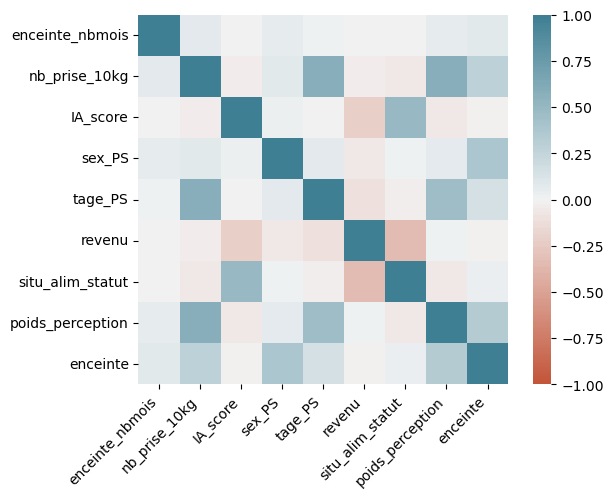

In [265]:
import seaborn as sns

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
    )

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Nous pouvons maintenant passer à la modélisation ! Sachant qu'on a déjà une *pipeline* qui contient les instructions pour le *preprocessing* il est très simple de rajouter une étape supplémentaire à cette pipeline afin de réaliser la modélisation. Pour estimer une régression linéaire nous allons utiliser une nouvelle fois une méthode de scikit-learn: `LinearRegression`. 

In [266]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

pipe_lr = Pipeline([
    ('preprocessor', preprocessor_regression), # 1ère étape réaliser le preprocessing
    ('regression', LinearRegression()) # 2ème étape estime notre régression linéaire
])

Comme précédemment, notre pipeline n'a pas été exécutée, nous l'avons seulement définie. Il est donc nécessaire de l'exécuter sur nos données grâce à la méthode `fit`.

In [267]:
lr = pipe_lr.fit(X_train_regression, y_train)

**Question 9:** Prédisez les indices de masse corporelles des individus de votre échantillon de test à l'aide de votre modèle. Evaluez le en calculant l'écart quadratique moyen (RMSE) et le R2.

In [268]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = lr.predict(X_test_regression)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Le RMSE sur le jeu de test est : {round(rmse, 4)}")
print(f"Le R2 sur le jeu de test est : {round(r2, 4)}")

Le RMSE sur le jeu de test est : 4.3542
Le R2 sur le jeu de test est : 0.4517


<details>
<summary>
    <font size=3 color="red"><b>Cliquez pour voir la réponse </b></font>
</summary>

```python
from sklearn.metrics import mean_squared_error, r2_score

y_pred = lr.predict(X_test_regression)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Le RMSE sur le jeu de test est : {round(rmse, 4)}")
print(f"Le R2 sur le jeu de test est : {round(r2, 4)}")
```

</details>

Il est difficile d'interpréter la valeur absolue du RMSE car il dépend de l'échelle et de la volatilité des données que nous cherchons à prédire. Regardons quelques statistiques de nl'IMC de nos individus de l'échantillons de test.

In [269]:
print(f"La variance de l'IMC de jeu de test est : {round(y_test.var(), 4)}")
print(f"La moyenne de l'IMC de jeu de test est : {round(y_test.mean(), 4)}")
print(f"L'écart interquartile de l'IMC de jeu de test est : {round(y_test.quantile(0.75) - y_test.quantile(0.25), 4)}")


La variance de l'IMC de jeu de test est : 34.6071
La moyenne de l'IMC de jeu de test est : 22.3912
L'écart interquartile de l'IMC de jeu de test est : 8.1963


On peut donc normaliser notre RMSE par l'une de ces statistiques pour avoir une idée plus précise des erreurs. La variance et la moyenne sont généralement les plus utilisées pour normaliser le RMSE.

In [270]:
print(f"Le RMSE sur le jeu de test équivaut à {round(rmse / y_test.var() * 100 , 2)}% de la variance de l'échantillon.")

Le RMSE sur le jeu de test équivaut à 12.58% de la variance de l'échantillon.


Une autre méthode qu'on ne saurait que vous recommander est une nouvelle fois la représentation graphique ! 

**Question 10:** Représentez graphiquement les valeurs prédites par rapport aux vraies valeurs.

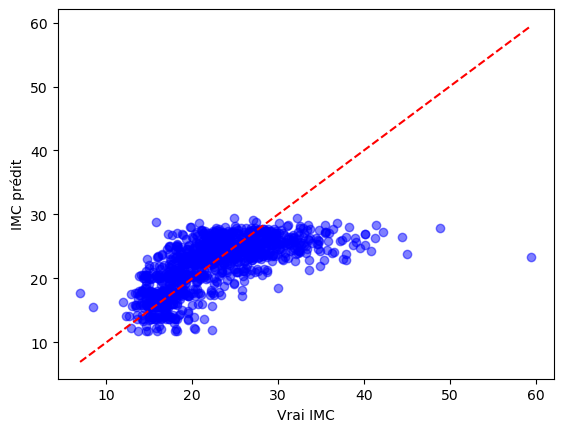

In [271]:
import matplotlib.pyplot as plt

# Creer le scatter plot
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)

# Ajout des labels
plt.xlabel('Vrai IMC')
plt.ylabel('IMC prédit')

# Ajout de la ligne à 45° comme référence
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

# Affichagedu graphique
plt.show()

<details>
<summary>
    <font size=3 color="red"><b>Cliquez pour voir la réponse </b></font>
</summary>

```python
import matplotlib.pyplot as plt

# Creer le scatter plot
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)

# Ajout des labels
plt.xlabel('Vrai IMC')
plt.ylabel('IMC prédit')

# Ajout de la ligne à 45° comme référence
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

# Affichagedu graphique
plt.show()
```

</details>

**Question 11:** Commentez le graphique.

- valeurs globalement alignées, mais pas tout à fait
- pour les Vrai IMC >30, le modèle a tendance à sous-estimer lors de la prédiction

### 3. Méthodes de Machine Learning

#### 3.1 Random Forest Regression


Grâce à scikit learn, on va voir qu'il est très facile d'utiliser des méthodes de machine learning différentes maintenant qu'on a utilisé les fonctions de base lors de la régression linéaire. 
Nous allons maintenant essayer d'utiliser l'intégralité des variables qui nous sont disponibles dans la base de données initiale. Cela implique de se replonger un petit peu dans l'analyse des données. Nous avons vu précédemment que toutes les variables numériques ne pouvaient pas être imputées par la médiane et que dans certains cas une imputation par 0 est préférable. 

**Question 12:** Répertoriez l'ensemble des variables numériques à imputer par 0 dans une liste.

In [276]:
NUMERICAL_0_IMPUT = [
        "enceinte_nbmois", "nb_prise_10kg", "nb_cigarettes_jour",  
    "nb_cigarettes_sem", "nb_cigares_jour", "nb_cigares_sem", 
    "nb_pipes_jour", "nb_pipes_sem", "allaite_nbsem", 
    "regime_nb_2dernann", "regime_nb_anter2dernann"
    ]

<details>
<summary>
    <font size=3 color="red"><b>Cliquez pour voir la réponse </b></font>
</summary>

```python
NUMERICAL_0_IMPUT = [
    "enceinte_nbmois", "nb_prise_10kg", "nb_cigarettes_jour",  
    "nb_cigarettes_sem", "nb_cigares_jour", "nb_cigares_sem", 
    "nb_pipes_jour", "nb_pipes_sem", "allaite_nbsem", 
    "regime_nb_2dernann", "regime_nb_anter2dernann"
    ]
```

</details>

**Question 13:** En vous aidant de ce qui a été fait précédemment, construisez un objet `preprocessor` qui imputera correctement toutes les variables de notre jeu de données d'entrainement, à savoir `X_train`.

In [277]:
zero_imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
minus_one_imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1)
median_imputer = SimpleImputer(missing_values=np.nan, strategy='median')

numerical_zero = make_pipeline(zero_imputer, StandardScaler())
numerical_median = make_pipeline(median_imputer, StandardScaler())
categorical_encoder = make_pipeline(minus_one_imputer, StandardScaler())

preprocessor = ColumnTransformer(
    transformers=[
        ("numerical_zero", numerical_zero, NUMERICAL_0_IMPUT),
        ("numerical_median", numerical_median, [x for x in NUMERICAL if x not in NUMERICAL_0_IMPUT]),
        ("categorical", categorical_encoder, CATEGORICAL)
    ]
)

<details>
<summary>
    <font size=3 color="red"><b>Cliquez pour voir la réponse </b></font>
</summary>

```python
zero_imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
minus_one_imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1)
median_imputer = SimpleImputer(missing_values=np.nan, strategy='median')

numerical_zero = make_pipeline(zero_imputer, StandardScaler())
numerical_median = make_pipeline(median_imputer, StandardScaler())
categorical_encoder = make_pipeline(minus_one_imputer, StandardScaler())

preprocessor = ColumnTransformer(
    transformers=[
        ("numerical_zero", numerical_zero, NUMERICAL_0_IMPUT),
        ("numerical_median", numerical_median, [x for x in NUMERICAL if x not in NUMERICAL_0_IMPUT]),
        ("categorical", categorical_encoder, CATEGORICAL)
    ]
)
```

</details>

**Question 14:** De la même manière que ce qui a été fait en 2., construisez une pipeline qui preprocesse vos données avant d'estimer un modèle Random Forest. N'oubliez pas de spécifier un `random_state` pour pouvoir répliquer vos résultats.

In [278]:
from sklearn.ensemble import RandomForestRegressor

pipe_rfr = Pipeline([
    ('preprocessor', preprocessor), 
    ('regression', RandomForestRegressor(random_state=SEED))
])

<details>
<summary>
    <font size=3 color="red"><b>Cliquez pour voir la réponse </b></font>
</summary>

```python
pipe_rfr = Pipeline([
    ('preprocessor', preprocessor), 
    ('regression', RandomForestRegressor(random_state=SEED))
])
```

</details>

Lorsque l'on entraine un modèle de machine on souhaite minimiser l'erreur de prédiction sur les données non utilisées lors de l'entrainement. Pour faire cela, il existe généralement 
plusieurs paramètres propres à chaque modèle que l'on peut faire varier de sorte à influer sur les performances. On utilise plus souvent le terme d'*hyperparamètre* que l'on cherche à *calibrer* (*fine-tune*), c'est-à-dire déterminer la combinaison d'hyperparamètres qui obtient la meilleure performance. Pour pouvoir calibrer ces hyperparamètres nous avons besoins de connaitre quels sont ceux des modèles Ra&ndom Forest, pour cela on peut utiliser la commande suivante : 

In [279]:
pipe_rfr['regression'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2023,
 'verbose': 0,
 'warm_start': False}

On voit que `scikit-learn` fournit directement des valeurs par défauts pour ces hyperparamètres et ces valeurs par défaut sont généralement des bonnes valeurs pour commencer. En plus de ces paramètres par défaut nous allons également tester d'autres combinaisons avec la méthode dites de *grid search* qui consiste simplement à tester toutes les combinaisons possibles parmi un ensemble de valeurs pour chaque paramètre à optimiser. Pour le moment nous allons choisir les paramètres `n_estimators` et `max_leaf_nodes` dont vous pouvez retrouver la signification dans la [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

In [280]:
param_grid = {
    "regression__n_estimators": [50, 100, 200],
    "regression__max_leaf_nodes": [5, 10, 50, None]
}

De sorte à limiter l'*overfitting* en calibrant les hyperparamètres nous allons également utiliser la méthode de *cross-validation* à 5 blocs (qui est très bien expliquée [ici](https://scikit-learn.org/stable/modules/cross_validation.html)). Pour effectuer tout cela, `scikit-learn` fournit une nouvelle fois une fonction particulièrement utile : `GridSearchCV()`.

In [282]:
from sklearn.model_selection import GridSearchCV

pipe_gscv = GridSearchCV(pipe_rfr, 
                         param_grid=param_grid, 
                         scoring=["explained_variance", "r2", "neg_root_mean_squared_error"],
                         refit="neg_root_mean_squared_error",
                         cv=5, 
                         n_jobs=-1, 
                         verbose=1)

**Question 14:** Pouvez vous deviner le nombre de `fit` total que nous allons effectuer lorsque nous allons appeler la méthode `fit` sur l'objet `pipe_rfr` ?

<details>
<summary>
    <font size=3 color="red"><b>Cliquez pour voir la réponse </b></font>
</summary>

Pour le grid search nous avons $3*4=12$ modèles à entrainer. Cependant, pour chaque combinaison nous effectuons une cross validation à $5$ blocs ce qui implique 5 entrainements pour chaque combinaisons tester. A la fin, nous avons donc à entrainer $60$ modèles.

</details>

In [ ]:
rfr = pipe_gscv.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [ ]:
print(f"Meilleure combinaison retenue: {rfr.best_params_}")

Il est possible d'accéder aux résultats de tous les modèles entrainés afin de comparer les performances.

In [ ]:
perf_random_forest = pd.DataFrame(rfr.cv_results_)
perf_random_forest

**Question 15:** Calculez les mêmes métriques que pour la régression linéaire et comparez la performance entre les deux modèles.

In [ ]:
# VOTRE CODE

<details>
<summary>
    <font size=3 color="red"><b>Cliquez pour voir la réponse </b></font>
</summary>

```python
y_pred = rfr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Le RMSE sur le jeu de test est : {round(rmse, 4)}")
print(f"Le R2 sur le jeu de test est : {round(r2, 4)}")
print(f"Le RMSE sur le jeu de test équivaut à {round(rmse / y_test.var() * 100 , 2)}% de la variance de l'échantillon.")
```
</details>

**Question 16:** Reproduisez le graphique représentant les valeurs prédites par rapport aux vraies valeurs et observez visuellement la différence de performance.

In [ ]:
# VOTRE CODE

<details>
<summary>
    <font size=3 color="red"><b>Cliquez pour voir la réponse </b></font>
</summary>

```python
# Create the scatter plot
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)

# Add labels and title
plt.xlabel('Actual IMC')
plt.ylabel('Predicted IMC')
plt.title('Scatter Plot of Predicted IMC vs Actual IMC')

# Add a diagonal line for reference
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

# Display the plot
plt.show()
```
</details>

#### 3.2 D'autres méthodes de machine learning

L'une des grandes forces de `scikit-learn` est que tout a été pensé pour que les fonctions soient extrêmement modulaire. Ainsi, une fois que l'on a un preprocessing bien défini, il est très facile de tester différents modèles pour savoir lesquels sont les mieux adaptés à nos jeux de données. Nous allons maintenant appliquer 3 autres méthodes, à savoir : 
- Les **Support Vectors Machines** (SVM) : documentation [ici](https://scikit-learn.org/stable/modules/svm.html),
- L'**eXtreme Gradient Boosting** (XGBoost) : documentation [ici](https://xgboost.readthedocs.io/en/stable/),
- La régression par les **plus proches voisins** (KNN) : documentation [ici](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html),


**Question 17:** En reprenant la même trame que pour la méthode des *Random Forests*, essayez de trouver le modèle le plus performant en utilisant les **SVM**.

In [ ]:
from sklearn.svm import SVR

# VOTRE CODE

<details>
<summary>
    <font size=3 color="red"><b>Cliquez pour voir la réponse </b></font>
</summary>

```python
from sklearn.svm import SVR

pipeline_svr = Pipeline([
    ('preprocessor', preprocessor), 
    ('regression', SVR())
])

param_grid = {
    "regression__C": np.logspace(-8, 8, 9, base=2), 
    "regression__kernel": ["rbf"],
    "regression__gamma": [0.01],
}

pipe_gscv = GridSearchCV(pipeline_svr, 
                         param_grid=param_grid, 
                         scoring=["explained_variance", "r2", "neg_root_mean_squared_error"],
                         refit="neg_root_mean_squared_error",
                         cv=5, 
                         n_jobs=-1, 
                         verbose=1)
                         
svr = pipe_gscv.fit(X_train, y_train)
print(f"Meilleure combinaison retenue: {svr.best_params_}")

y_pred = svr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Le RMSE sur le jeu de test est : {round(rmse, 4)}")
print(f"Le R2 sur le jeu de test est : {round(r2, 4)}")
print(f"Le RMSE sur le jeu de test équivaut à {round(rmse / y_test.var() * 100 , 2)}% de la variance de l'échantillon.")
```
</details>

**Question 18:** De même, essayez de trouver le modèle le plus performant en utilisant le **XGBoost**.

In [283]:
from xgboost import XGBRegressor

pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor), 
    ('regression', XGBRegressor(random_state=SEED))
])

param_grid = {
    "regression__max_leaves": [5, 10, 25],
    "regression__max_depth": [2, 3, 5],
    "regression__gamma": [0.1, 0.25, 0.5],
    "regression__n_estimators": [75, 150, 250],
}

pipe_gscv = GridSearchCV(pipeline_xgb, 
                         param_grid=param_grid, 
                         scoring=["explained_variance", "r2", "neg_root_mean_squared_error"],
                         refit="neg_root_mean_squared_error",
                         cv=5, 
                         n_jobs=-1, 
                         verbose=1)
                         
xgb = pipe_gscv.fit(X_train, y_train)
print(f"Meilleure combinaison retenue: {xgb.best_params_}")

y_pred = xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Le RMSE sur le jeu de test est : {round(rmse, 4)}")
print(f"Le R2 sur le jeu de test est : {round(r2, 4)}")
print(f"Le RMSE sur le jeu de test équivaut à {round(rmse / y_test.var() * 100 , 2)}% de la variance de l'échantillon.")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Meilleure combinaison retenue: {'regression__gamma': 0.25, 'regression__max_depth': 5, 'regression__max_leaves': 5, 'regression__n_estimators': 75}
Le RMSE sur le jeu de test est : 1.5933
Le R2 sur le jeu de test est : 0.9266
Le RMSE sur le jeu de test équivaut à 4.6% de la variance de l'échantillon.


In [294]:
pipeline_xgb['regression'].get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 2023,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [293]:
# Bonus : essayons de mieux tuner le modèle
# RMSE à battre : 1.5933

from xgboost import XGBRegressor

pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor), 
    ('regression', XGBRegressor(random_state=SEED))
])

param_grid = {
    "regression__max_leaves": [5, 10, 25],
    "regression__max_depth": [2, 3, 5],
    "regression__gamma": [0.1, 0.25, 0.5],
    "regression__n_estimators": [ 10*k for k in range(0,21) ],
    "regression__learning_rate": [ k*0.1 for k in range(0,5) ]
}

pipe_gscv = GridSearchCV(pipeline_xgb, 
                         param_grid=param_grid, 
                         scoring=["explained_variance", "r2", "neg_root_mean_squared_error"],
                         refit="neg_root_mean_squared_error",
                         cv=5, 
                         n_jobs=-1, 
                         verbose=3)
                         
xgb = pipe_gscv.fit(X_train, y_train)
print(f"Meilleure combinaison retenue: {xgb.best_params_}")

y_pred = xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Le RMSE sur le jeu de test est : {round(rmse, 4)}")
print(f"Le R2 sur le jeu de test est : {round(r2, 4)}")
print(f"Le RMSE sur le jeu de test équivaut à {round(rmse / y_test.var() * 100 , 2)}% de la variance de l'échantillon.")


Fitting 5 folds for each of 6237 candidates, totalling 31185 fits
[CV 5/5] END regression__gamma=0.1, regression__learning_rate=0.0, regression__max_depth=2, regression__max_leaves=5, regression__n_estimators=0; explained_variance: (test=0.000) neg_root_mean_squared_error: (test=-22.900) r2: (test=-14.734) total time=   0.1s
[CV 4/5] END regression__gamma=0.1, regression__learning_rate=0.0, regression__max_depth=2, regression__max_leaves=5, regression__n_estimators=60; explained_variance: (test=0.000) neg_root_mean_squared_error: (test=-22.379) r2: (test=-14.960) total time=   0.6s
[CV 1/5] END regression__gamma=0.1, regression__learning_rate=0.0, regression__max_depth=2, regression__max_leaves=5, regression__n_estimators=110; explained_variance: (test=0.000) neg_root_mean_squared_error: (test=-22.251) r2: (test=-14.432) total time=   1.2s
[CV 5/5] END regression__gamma=0.1, regression__learning_rate=0.0, regression__max_depth=2, regression__max_leaves=5, regression__n_estimators=160; 

KeyboardInterrupt: 

<details>
<summary>
    <font size=3 color="red"><b>Cliquez pour voir la réponse </b></font>
</summary>

```python
from xgboost import XGBRegressor

pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor), 
    ('regression', XGBRegressor(random_state=SEED))
])

param_grid = {
    "regression__max_leaves": [5, 10, 25],
    "regression__max_depth": [2, 3, 5],
    "regression__gamma": [0.1, 0.25, 0.5],
    "regression__n_estimators": [75, 150, 250],
}

pipe_gscv = GridSearchCV(pipeline_xgb, 
                         param_grid=param_grid, 
                         scoring=["explained_variance", "r2", "neg_root_mean_squared_error"],
                         refit="neg_root_mean_squared_error",
                         cv=5, 
                         n_jobs=-1, 
                         verbose=1)
                         
xgb = pipe_gscv.fit(X_train, y_train)
print(f"Meilleure combinaison retenue: {xgb.best_params_}")

y_pred = xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Le RMSE sur le jeu de test est : {round(rmse, 4)}")
print(f"Le R2 sur le jeu de test est : {round(r2, 4)}")
print(f"Le RMSE sur le jeu de test équivaut à {round(rmse / y_test.var() * 100 , 2)}% de la variance de l'échantillon.")
```
</details>

**Question 19:** De même, essayez de trouver le modèle le plus performant en utilisant les **K plus proches voisins**.

In [292]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor

pipeline_knn = Pipeline([
    ('preprocessor', preprocessor), 
    ('regression', KNeighborsRegressor())
])

param_grid = {
    "regression__n_neighbors": [3, 4, 5, 6],
    "regression__p": [1, 2, 3],
}

pipe_gscv = GridSearchCV(pipeline_knn, 
                         param_grid=param_grid, 
                         scoring=["explained_variance", "r2", "neg_root_mean_squared_error"],
                         refit="neg_root_mean_squared_error",
                         cv=5, 
                         n_jobs=-1, 
                         verbose=1)
                         
knn = pipe_gscv.fit(X_train, y_train)
print(f"Meilleure combinaison retenue: {knn.best_params_}")

y_pred = knn.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Le RMSE sur le jeu de test est : {round(rmse, 4)}")
print(f"Le R2 sur le jeu de test est : {round(r2, 4)}")
print(f"Le RMSE sur le jeu de test équivaut à {round(rmse / y_test.var() * 100 , 2)}% de la variance de l'échantillon.")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Meilleure combinaison retenue: {'regression__n_neighbors': 6, 'regression__p': 2}
Le RMSE sur le jeu de test est : 3.4711
Le R2 sur le jeu de test est : 0.6516
Le RMSE sur le jeu de test équivaut à 10.03% de la variance de l'échantillon.


<details>
<summary>
    <font size=3 color="red"><b>Cliquez pour voir la réponse </b></font>
</summary>

```python
from sklearn.neighbors import KNeighborsRegressor

pipeline_knn = Pipeline([
    ('preprocessor', preprocessor), 
    ('regression', KNeighborsRegressor())
])

param_grid = {
    "regression__n_neighbors": [3, 4, 5, 6],
    "regression__p": [1, 2, 3],
}

pipe_gscv = GridSearchCV(pipeline_knn, 
                         param_grid=param_grid, 
                         scoring=["explained_variance", "r2", "neg_root_mean_squared_error"],
                         refit="neg_root_mean_squared_error",
                         cv=5, 
                         n_jobs=-1, 
                         verbose=1)
                         
knn = pipe_gscv.fit(X_train, y_train)
print(f"Meilleure combinaison retenue: {knn.best_params_}")

y_pred = knn.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Le RMSE sur le jeu de test est : {round(rmse, 4)}")
print(f"Le R2 sur le jeu de test est : {round(r2, 4)}")
print(f"Le RMSE sur le jeu de test équivaut à {round(rmse / y_test.var() * 100 , 2)}% de la variance de l'échantillon.")
```
</details>

### 4. Pour aller plus loin

Précédemment nous avons réalisé que des tâches de régression. Les méthodes de machine learning peuvent aussi s'avérer particulièrement efficace pour effectuer des tâches de classification. Pour illustrer nos propos, essayons de transformer notre problème de régression en un problème de classification. 
Les valeurs de l'indice de masse corporelle peuvent donner lieu à plusieurs interprétations que l'on peut résumer dans le tableau suivant :

| IMC ($kg/m^2$) | Interprétation | Classe |
| --- | --- | --- |
|  $< 16.5$ | Dénutrition | 0 |
|  $16.5$ à $18.5$| Maigreur | 1 |
|  $18.5$ à $25$| Poids normal | 2 |
|  $25$ à $30$| Surpoids | 3 |
|  $30$ à $35$| Obésité modérée | 4 |
|  $35$ à $40$| Obésité sévère | 5 |
|  $> 40$ | Obésité morbide | 6 |

**Question 20:** Créer deux variables `y_train_class` et `y_test_class` de sorte à ce les valeurs des IMC soient remplacées par la classe à laquelle ils appartiennt. Par exemple, si l'IMC est égal à 23 alors on renverra la valeur 3.

In [284]:
y_train_class = y_train.apply(
        lambda imc: 1
        if imc < 16.5
        else 2
        if 16.5 <= imc < 18.5
        else 3
        if 18.5 <= imc < 25
        else 4
        if 25 <= imc < 30
        else 5
        if 30 <= imc < 35
        else 6
        if 35 <= imc < 40
        else 7
    )

y_test_class = y_test.apply(
        lambda imc: 1
        if imc < 16.5
        else 2
        if 16.5 <= imc < 18.5
        else 3
        if 18.5 <= imc < 25
        else 4
        if 25 <= imc < 30
        else 5
        if 30 <= imc < 35
        else 6
        if 35 <= imc < 40
        else 7
    )

In [287]:
y_test , y_test_class

(4679    22.938578
 4639    27.309969
 3162    18.582815
 3658    30.367348
 1548    29.270994
           ...    
 4454    16.141529
 2123    18.365473
 399     27.362715
 3074    17.348541
 2496    26.813591
 Name: imc, Length: 1169, dtype: float64,
 4679    3
 4639    4
 3162    3
 3658    5
 1548    4
        ..
 4454    1
 2123    2
 399     4
 3074    2
 2496    4
 Name: imc, Length: 1169, dtype: int64)

<details>
<summary>
    <font size=3 color="red"><b>Cliquez pour voir la réponse </b></font>
</summary>

```python
y_train_class = y_train.apply(
        lambda imc: 1
        if imc < 16.5
        else 2
        if 16.5 <= imc < 18.5
        else 3
        if 18.5 <= imc < 25
        else 4
        if 25 <= imc < 30
        else 5
        if 30 <= imc < 35
        else 6
        if 35 <= imc < 40
        else 7
    )

y_test_class = y_test.apply(
        lambda imc: 1
        if imc < 16.5
        else 2
        if 16.5 <= imc < 18.5
        else 3
        if 18.5 <= imc < 25
        else 4
        if 25 <= imc < 30
        else 5
        if 30 <= imc < 35
        else 6
        if 35 <= imc < 40
        else 7
    )
```
</details>

**Question 21:** Essayez plusieurs de méthodes de machine learning de classification sur ce nouveau problème.

In [ ]:
# A VOUS DE JOUER

<details>
<summary>
    <font size=3 color="red"><b>Cliquer pour voir une proposition de solution </b></font>
</summary>

```python
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor), 
    ('classification', XGBClassifier(random_state=SEED))
])

param_grid = {
    "classification__max_leaves": [5, 10, 25],
    "classification__max_depth": [2, 3, 5],
    "classification__gamma": [0.1, 0.25, 0.5],
    "classification__n_estimators": [75, 150, 250],
}

pipe_gscv = GridSearchCV(pipeline_xgb, 
                         param_grid=param_grid, 
                         scoring=["accuracy", "f1_weighted"],
                         refit="f1_weighted",
                         cv=5, 
                         n_jobs=-1, 
                         verbose=1)
                         
xgb = pipe_gscv.fit(X_train, y_train_class)
print(f"Meilleure combinaison retenue: {xgb.best_params_}")

y_pred = xgb.predict(X_test)
print(classification_report(y_test_class, y_pred))

ConfusionMatrixDisplay.from_estimator(
    xgb,
    X_test,
    y_test_class,
    cmap=plt.cm.Blues,
    normalize="true",
)
```
</details>

**Pour aller plus loin:** Comparez les performances de classification entre votre meilleur modèle de classification et votre meilleur modèle de régression pour lequel vous reconstruisez les classes prédites selon la valeurs exactes prédites.

# Fin :)